<a href="https://colab.research.google.com/github/BrainConnection/Quantum_Algorithm/blob/main/5.%205Q%20TFIM%20VQNHE%20CNN%20QEM%20Bit%20Flip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [ ]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install qiskit[visualization]
!pip install qiskit-algorithms
!pip install qiskit-aer

!pip install scipy
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.0/318.0 kB 23.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 7.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
    

In [ ]:
from functools import cache

from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Options

# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(channel="ibm_quantum",
                                  token="067e5c82606f0a1157dd554e2087d6b7a9b823dbaa4ad47b95c3337eab2e6cd9361719cc0470f4a98d1631b73b264a82577012a0b8ff32963d5964e6cc12c525",
                                  set_as_default=True,
                                  overwrite=True)

service = QiskitRuntimeService()
backend = service.backend("ibmq_qasm_simulator")

# Hamiltonian Diagonalization

$$ H = Σ Z_j Z_{j+1} - Σ X_j  $$

1D 5 Qubit System

In [ ]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
hamiltonian_matrix = hamiltonian.to_matrix()

eigenvalue, eigenvector = np.linalg.eig(hamiltonian_matrix)

lowest_energy = np.min(eigenvalue)

np.real(lowest_energy)

-6.026674183332294

# 6. CNN Estimation - Bit Flip Channel

## Bit Flip Channel, Error 0.001~0.1, Shots = 100000, FC Hidden Layer 1개

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

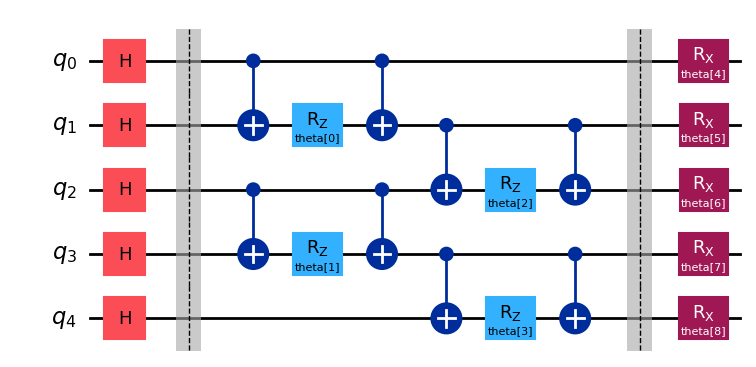

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

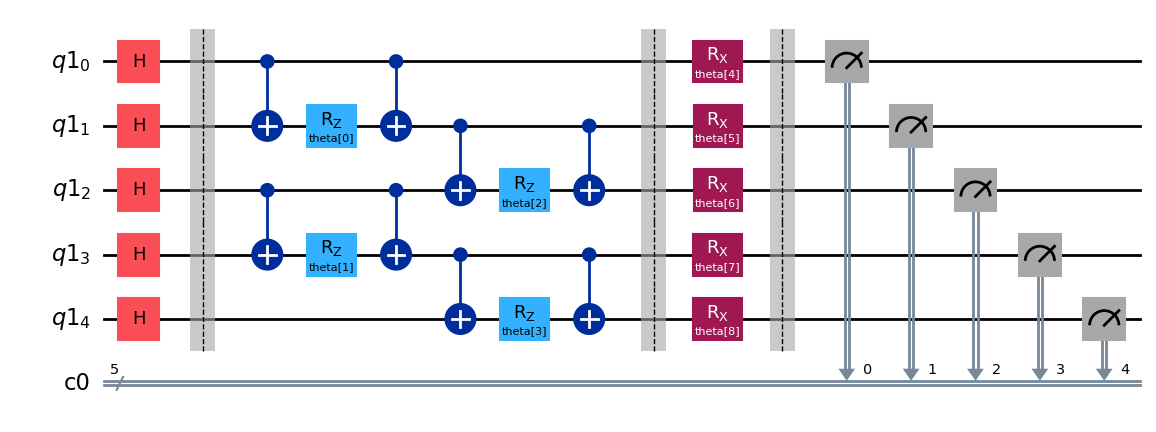

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

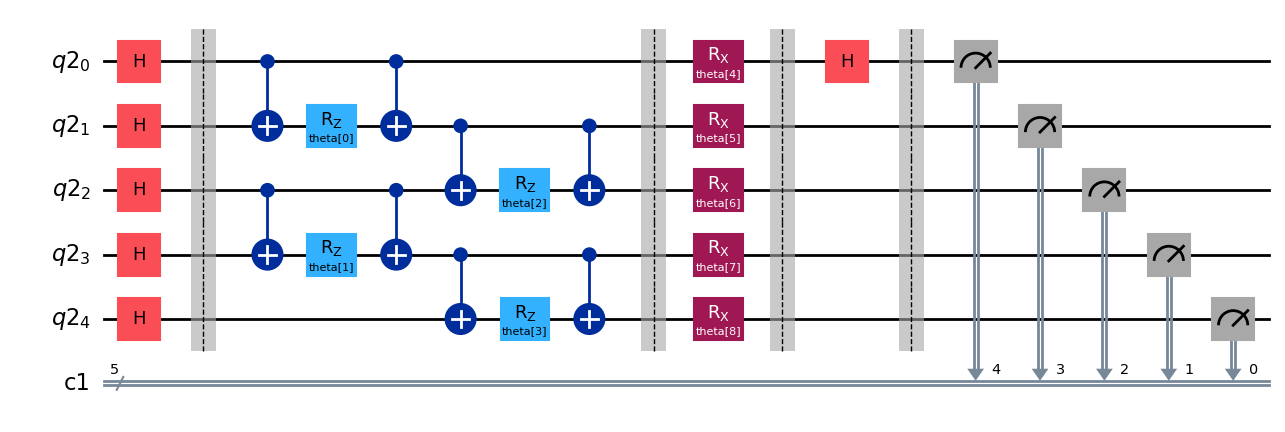

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

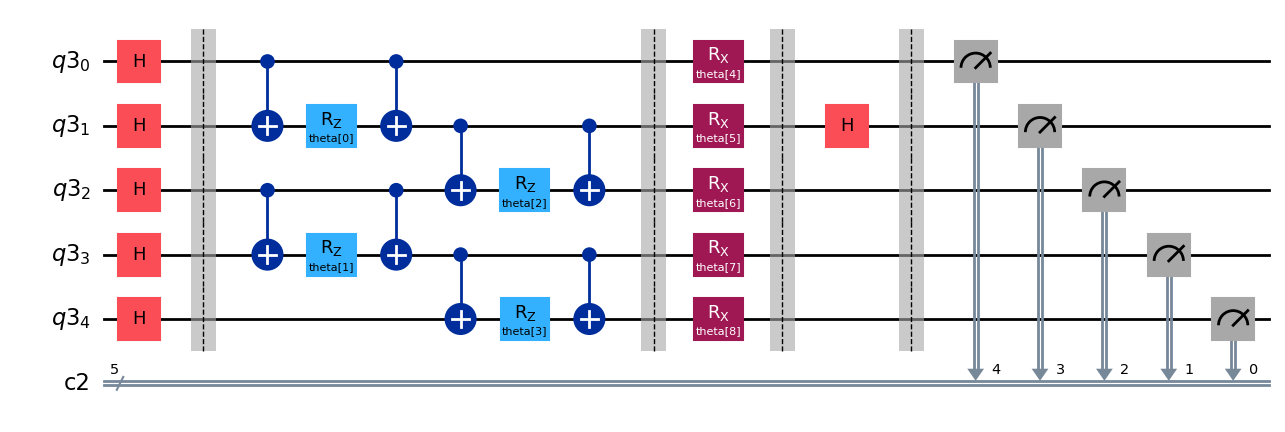

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

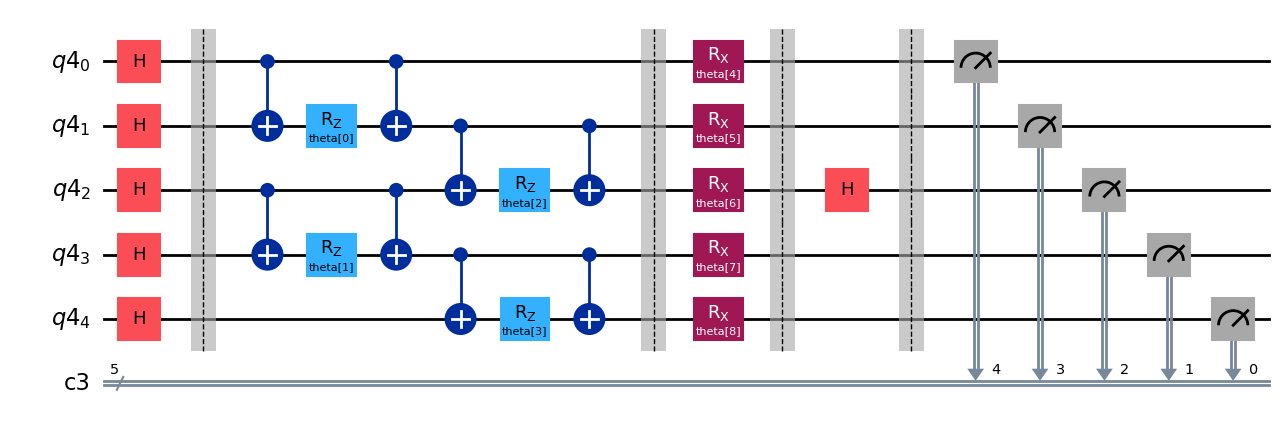

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

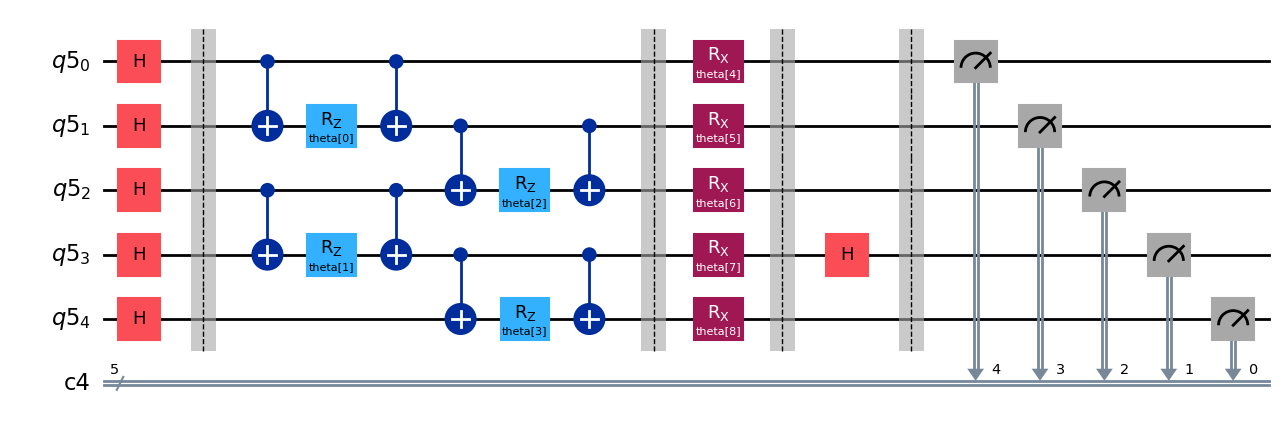

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

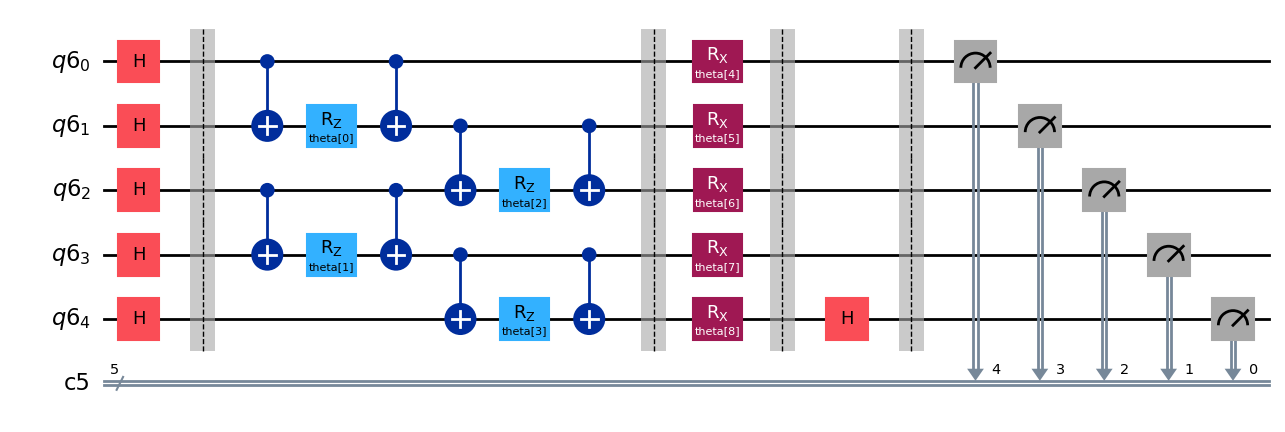

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


def cnn(a, b, c, x):
  lst = []
  lst.append(b*x[0]+c*x[1])
  lst.append(a*x[0]+b*x[1]+c*x[2])
  lst.append(a*x[1]+b*x[2]+c*x[3])
  lst.append(a*x[2]+b*x[3]+c*x[4])
  lst.append(a*x[3]+b*x[4])

  return np.array(lst)


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  FC1 = parameter[0:25]
  FC2 = parameter[25:30]
  c = parameter[30]

  FC1 = FC1.reshape(5,5)
  FC2 = FC2.reshape(1,5)

  a1 = np.matmul(FC1, x)
  z1 = relu(a1)

  a2 = np.matmul(FC2, z1)
  y = output_activate(c, a2)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=100000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1]

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  bitflip_prob = error_list[num]

  bit1 = pauli_error([('X', bitflip_prob), ('I', 1 - bitflip_prob)])
  bit2 = bit1.tensor(bit1)

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(bit1, ["u1", "u2", "u3"])
  noise_model.add_all_qubit_quantum_error(bit2, ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=31), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=31), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(bitflip_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

error rate : 0.0, lowest energy vqe : -5.876600000000001

error rate : 0.001, lowest energy vqe : -5.878239999999999

error rate : 0.002, lowest energy vqe : -5.87098

error rate : 0.003, lowest energy vqe : -5.860439999999999

error rate : 0.004, lowest energy vqe : -5.8485000000000005

error rate : 0.005, lowest energy vqe : -5.8170600000000015

error rate : 0.006, lowest energy vqe : -5.824020000000002

error rate : 0.007, lowest energy vqe : -5.820760000000001

error rate : 0.008, lowest energy vqe : -5.8051200000000005

error rate : 0.009000000000000001, lowest energy vqe : -5.798660000000001

error rate : 0.01, lowest energy vqe : -5.77824

error rate : 0.02, lowest energy vqe : -5.684420000000001

error rate : 0.03, lowest energy vqe : -5.59114

error rate : 0.04, lowest energy vqe : -5.51376

error rate : 0.05, lowest energy vqe : -5.46274

error rate : 0.06, lowest energy vqe : -5.3962200000000005

error rate : 0.07, lowest energy vqe : -5.35034

error rate : 0.08, lowest ener

In [ ]:
lowest_energy_vqe_list

[-5.876600000000001,
 -5.878239999999999,
 -5.87098,
 -5.860439999999999,
 -5.8485000000000005,
 -5.8170600000000015,
 -5.824020000000002,
 -5.820760000000001,
 -5.8051200000000005,
 -5.798660000000001,
 -5.77824,
 -5.684420000000001,
 -5.59114,
 -5.51376,
 -5.46274,
 -5.3962200000000005,
 -5.35034,
 -5.310279999999999,
 -5.273199999999999,
 -5.24208]

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  bitflip_prob = error_list[num]

  bit1 = pauli_error([('X', bitflip_prob), ('I', 1 - bitflip_prob)])
  bit2 = bit1.tensor(bit1)

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(bit1, ["u1", "u2", "u3"])
  noise_model.add_all_qubit_quantum_error(bit2, ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=31), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=31), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(bitflip_prob, lowest_energy_vqe))
  print()


  for k in range(num*100+10, num*100+20, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(31) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 300
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if local_minimum_dict[-1] < lowest_energy_vqnhe:
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(bitflip_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

error rate : 0.0, lowest energy vqe : -5.876600000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.983909
         Iterations: 98
         Function evaluations: 6917
         Gradient evaluations: 216


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.963847
         Iterations: 300
         Function evaluations: 14144
         Gradient evaluations: 442


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.956332
         Iterations: 110
         Function evaluations: 5287
         Gradient evaluations: 165
Optimization terminated successfully.
         Current function value: -5.946518
         Iterations: 172
         Function evaluations: 6208
         Gradient evaluations: 194


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.006697
         Iterations: 300
         Function evaluations: 13568
         Gradient evaluations: 424


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.959239
         Iterations: 116
         Function evaluations: 7276
         Gradient evaluations: 227


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.008487
         Iterations: 300
         Function evaluations: 13056
         Gradient evaluations: 408


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.000965
         Iterations: 137
         Function evaluations: 8076
         Gradient evaluations: 252


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.955755
         Iterations: 150
         Function evaluations: 9536
         Gradient evaluations: 298


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.004269
         Iterations: 300
         Function evaluations: 13376
         Gradient evaluations: 418
error rate : 0.0, lowest energy vqnhe : -6.0084873368912



error rate : 0.001, lowest energy vqe : -5.878239999999999

Optimization terminated successfully.
         Current function value: -5.966474
         Iterations: 92
         Function evaluations: 3808
         Gradient evaluations: 119
Optimization terminated successfully.
         Current function value: -5.965480
         Iterations: 65
         Function evaluations: 2464
         Gradient evaluations: 77
         Current function value: -6.020689
         Iterations: 300
         Function evaluations: 12480
         Gradient evaluations: 390
Optimization terminated successfully.
         Current function value: -5.967212
         Iterations: 141
         Function evaluations: 6368
         Gradient evaluations: 199
Optimization terminated successfully.
         Current function value: -

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.016368
         Iterations: 192
         Function evaluations: 8171
         Gradient evaluations: 255


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.003942
         Iterations: 96
         Function evaluations: 7083
         Gradient evaluations: 221
Optimization terminated successfully.
         Current function value: -5.971687
         Iterations: 102
         Function evaluations: 4160
         Gradient evaluations: 130


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.021184
         Iterations: 123
         Function evaluations: 5507
         Gradient evaluations: 172
error rate : 0.001, lowest energy vqnhe : -6.021183539878755



error rate : 0.002, lowest energy vqe : -5.87098



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.011980
         Iterations: 191
         Function evaluations: 10251
         Gradient evaluations: 320


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.014685
         Iterations: 248
         Function evaluations: 11786
         Gradient evaluations: 368


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.014944
         Iterations: 300
         Function evaluations: 11392
         Gradient evaluations: 356
Optimization terminated successfully.
         Current function value: -5.912638
         Iterations: 91
         Function evaluations: 3808
         Gradient evaluations: 119
Optimization terminated successfully.
         Current function value: -5.997825
         Iterations: 124
         Function evaluations: 4320
         Gradient evaluations: 135


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.956799
         Iterations: 102
         Function evaluations: 5640
         Gradient evaluations: 176


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.952771
         Iterations: 300
         Function evaluations: 11904
         Gradient evaluations: 372


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.009068
         Iterations: 130
         Function evaluations: 6539
         Gradient evaluations: 204


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.006849
         Iterations: 173
         Function evaluations: 8876
         Gradient evaluations: 277
Optimization terminated successfully.
         Current function value: -5.943885
         Iterations: 167
         Function evaluations: 6208
         Gradient evaluations: 194
error rate : 0.002, lowest energy vqnhe : -6.014943822537005



error rate : 0.003, lowest energy vqe : -5.860439999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.990394
         Iterations: 86
         Function evaluations: 5068
         Gradient evaluations: 158


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.972018
         Iterations: 103
         Function evaluations: 6248
         Gradient evaluations: 195


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.013927
         Iterations: 156
         Function evaluations: 6984
         Gradient evaluations: 218
Optimization terminated successfully.
         Current function value: -6.010958
         Iterations: 128
         Function evaluations: 4320
         Gradient evaluations: 135


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.015817
         Iterations: 300
         Function evaluations: 12448
         Gradient evaluations: 389
Optimization terminated successfully.
         Current function value: -5.912008
         Iterations: 124
         Function evaluations: 4768
         Gradient evaluations: 149


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.017577
         Iterations: 171
         Function evaluations: 7564
         Gradient evaluations: 236


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.010989
         Iterations: 271
         Function evaluations: 12232
         Gradient evaluations: 382


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.980182
         Iterations: 204
         Function evaluations: 12681
         Gradient evaluations: 396


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.011827
         Iterations: 114
         Function evaluations: 5606
         Gradient evaluations: 175
error rate : 0.003, lowest energy vqnhe : -6.017577446956279



error rate : 0.004, lowest energy vqe : -5.8485000000000005



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.001717
         Iterations: 300
         Function evaluations: 12672
         Gradient evaluations: 396


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.995571
         Iterations: 183
         Function evaluations: 10188
         Gradient evaluations: 318


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.999462
         Iterations: 300
         Function evaluations: 10688
         Gradient evaluations: 334


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.994985
         Iterations: 155
         Function evaluations: 7040
         Gradient evaluations: 220


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.984240
         Iterations: 125
         Function evaluations: 7212
         Gradient evaluations: 225


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.998037
         Iterations: 244
         Function evaluations: 11144
         Gradient evaluations: 348


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.993245
         Iterations: 283
         Function evaluations: 12896
         Gradient evaluations: 403


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.996210
         Iterations: 187
         Function evaluations: 9960
         Gradient evaluations: 311


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.997076
         Iterations: 174
         Function evaluations: 10950
         Gradient evaluations: 342
Optimization terminated successfully.
         Current function value: -5.958193
         Iterations: 144
         Function evaluations: 7296
         Gradient evaluations: 228
error rate : 0.004, lowest energy vqnhe : -6.001716601901884



error rate : 0.005, lowest energy vqe : -5.8170600000000015

Optimization terminated successfully.
         Current function value: -5.979297
         Iterations: 152
         Function evaluations: 5280
         Gradient evaluations: 165


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.980280
         Iterations: 166
         Function evaluations: 8203
         Gradient evaluations: 256


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.975793
         Iterations: 300
         Function evaluations: 12864
         Gradient evaluations: 402
Optimization terminated successfully.
         Current function value: -5.913121
         Iterations: 121
         Function evaluations: 5184
         Gradient evaluations: 162


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.982749
         Iterations: 78
         Function evaluations: 4450
         Gradient evaluations: 139


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.984655
         Iterations: 249
         Function evaluations: 13451
         Gradient evaluations: 420


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.984409
         Iterations: 199
         Function evaluations: 10604
         Gradient evaluations: 331
Optimization terminated successfully.
         Current function value: -5.979453
         Iterations: 183
         Function evaluations: 7872
         Gradient evaluations: 246


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.965575
         Iterations: 152
         Function evaluations: 8779
         Gradient evaluations: 274


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.986636
         Iterations: 213
         Function evaluations: 10060
         Gradient evaluations: 314
error rate : 0.005, lowest energy vqnhe : -5.986636363681208



error rate : 0.006, lowest energy vqe : -5.824020000000002



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.906770
         Iterations: 69
         Function evaluations: 5610
         Gradient evaluations: 175


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.978547
         Iterations: 250
         Function evaluations: 10464
         Gradient evaluations: 327
Optimization terminated successfully.
         Current function value: -5.969845
         Iterations: 114
         Function evaluations: 4064
         Gradient evaluations: 127


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.984354
         Iterations: 300
         Function evaluations: 11392
         Gradient evaluations: 356


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.970081
         Iterations: 177
         Function evaluations: 7943
         Gradient evaluations: 248


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.960816
         Iterations: 300
         Function evaluations: 12448
         Gradient evaluations: 389


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.978464
         Iterations: 223
         Function evaluations: 11944
         Gradient evaluations: 373
Optimization terminated successfully.
         Current function value: -5.873106
         Iterations: 217
         Function evaluations: 11904
         Gradient evaluations: 372
Optimization terminated successfully.
         Current function value: -5.869310
         Iterations: 265
         Function evaluations: 12064
         Gradient evaluations: 377


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.974012
         Iterations: 300
         Function evaluations: 11264
         Gradient evaluations: 352
error rate : 0.006, lowest energy vqnhe : -5.984354002554103



error rate : 0.007, lowest energy vqe : -5.820760000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.989494
         Iterations: 119
         Function evaluations: 5516
         Gradient evaluations: 172


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.992442
         Iterations: 173
         Function evaluations: 10187
         Gradient evaluations: 318


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.989209
         Iterations: 150
         Function evaluations: 7308
         Gradient evaluations: 228
Optimization terminated successfully.
         Current function value: -5.878140
         Iterations: 114
         Function evaluations: 4352
         Gradient evaluations: 136


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.983929
         Iterations: 84
         Function evaluations: 3756
         Gradient evaluations: 117
Optimization terminated successfully.
         Current function value: -5.983365
         Iterations: 134
         Function evaluations: 5216
         Gradient evaluations: 163


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.986102
         Iterations: 300
         Function evaluations: 10912
         Gradient evaluations: 341


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.980304
         Iterations: 221
         Function evaluations: 10950
         Gradient evaluations: 342


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.996982
         Iterations: 300
         Function evaluations: 12928
         Gradient evaluations: 404


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.886231
         Iterations: 110
         Function evaluations: 6438
         Gradient evaluations: 201
error rate : 0.007, lowest energy vqnhe : -5.996982454677312



error rate : 0.008, lowest energy vqe : -5.8051200000000005



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.951918
         Iterations: 86
         Function evaluations: 5093
         Gradient evaluations: 159
Optimization terminated successfully.
         Current function value: -5.957450
         Iterations: 158
         Function evaluations: 5920
         Gradient evaluations: 185


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.968174
         Iterations: 190
         Function evaluations: 9285
         Gradient evaluations: 290


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.970664
         Iterations: 194
         Function evaluations: 9703
         Gradient evaluations: 303
Optimization terminated successfully.
         Current function value: -5.967563
         Iterations: 129
         Function evaluations: 4896
         Gradient evaluations: 153


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.957789
         Iterations: 158
         Function evaluations: 7340
         Gradient evaluations: 229


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.961533
         Iterations: 113
         Function evaluations: 5831
         Gradient evaluations: 182


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.911514
         Iterations: 252
         Function evaluations: 12615
         Gradient evaluations: 394


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.963174
         Iterations: 300
         Function evaluations: 15072
         Gradient evaluations: 471
         Current function value: -5.972634
         Iterations: 300
         Function evaluations: 12064
         Gradient evaluations: 377
error rate : 0.008, lowest energy vqnhe : -5.972633791317975



error rate : 0.009000000000000001, lowest energy vqe : -5.798660000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.963132
         Iterations: 168
         Function evaluations: 8171
         Gradient evaluations: 255


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.920071
         Iterations: 143
         Function evaluations: 8357
         Gradient evaluations: 261
Optimization terminated successfully.
         Current function value: -5.973846
         Iterations: 126
         Function evaluations: 4288
         Gradient evaluations: 134


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.978328
         Iterations: 300
         Function evaluations: 11456
         Gradient evaluations: 358


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.967911
         Iterations: 242
         Function evaluations: 11561
         Gradient evaluations: 361
Optimization terminated successfully.
         Current function value: -5.884684
         Iterations: 62
         Function evaluations: 3264
         Gradient evaluations: 102


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.977270
         Iterations: 300
         Function evaluations: 10528
         Gradient evaluations: 329


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.979477
         Iterations: 219
         Function evaluations: 8448
         Gradient evaluations: 264


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.975511
         Iterations: 300
         Function evaluations: 11552
         Gradient evaluations: 361


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.943308
         Iterations: 208
         Function evaluations: 11750
         Gradient evaluations: 367
error rate : 0.009000000000000001, lowest energy vqnhe : -5.979476782939116



error rate : 0.01, lowest energy vqe : -5.77824



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.969206
         Iterations: 57
         Function evaluations: 3628
         Gradient evaluations: 113


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.964977
         Iterations: 188
         Function evaluations: 8224
         Gradient evaluations: 257


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.967427
         Iterations: 147
         Function evaluations: 6732
         Gradient evaluations: 210


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.965091
         Iterations: 195
         Function evaluations: 10279
         Gradient evaluations: 321


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.980319
         Iterations: 300
         Function evaluations: 13024
         Gradient evaluations: 407
         Current function value: -5.977920
         Iterations: 300
         Function evaluations: 13888
         Gradient evaluations: 434
         Current function value: -5.979155
         Iterations: 300
         Function evaluations: 11936
         Gradient evaluations: 373
         Current function value: -5.979179
         Iterations: 300
         Function evaluations: 10976
         Gradient evaluations: 343


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.953087
         Iterations: 224
         Function evaluations: 13702
         Gradient evaluations: 428
Optimization terminated successfully.
         Current function value: -5.965756
         Iterations: 124
         Function evaluations: 4288
         Gradient evaluations: 134
error rate : 0.01, lowest energy vqnhe : -5.980319277725781



error rate : 0.02, lowest energy vqe : -5.684420000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.978534
         Iterations: 146
         Function evaluations: 8839
         Gradient evaluations: 276


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.959709
         Iterations: 300
         Function evaluations: 12512
         Gradient evaluations: 391


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.942481
         Iterations: 134
         Function evaluations: 9479
         Gradient evaluations: 296


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.860860
         Iterations: 118
         Function evaluations: 4480
         Gradient evaluations: 140


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.978244
         Iterations: 300
         Function evaluations: 11552
         Gradient evaluations: 361


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.989171
         Iterations: 144
         Function evaluations: 7724
         Gradient evaluations: 241
Optimization terminated successfully.
         Current function value: -5.782727
         Iterations: 64
         Function evaluations: 2752
         Gradient evaluations: 86
Optimization terminated successfully.
         Current function value: -5.783431
         Iterations: 44
         Function evaluations: 1504
         Gradient evaluations: 47


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.975715
         Iterations: 95
         Function evaluations: 5452
         Gradient evaluations: 170


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.981124
         Iterations: 184
         Function evaluations: 10312
         Gradient evaluations: 322
error rate : 0.02, lowest energy vqnhe : -5.989171000294582



error rate : 0.03, lowest energy vqe : -5.59114

Optimization terminated successfully.
         Current function value: -5.981846
         Iterations: 104
         Function evaluations: 4224
         Gradient evaluations: 132
Optimization terminated successfully.
         Current function value: -5.858557
         Iterations: 95
         Function evaluations: 3520
         Gradient evaluations: 110


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.000295
         Iterations: 212
         Function evaluations: 10284
         Gradient evaluations: 321


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.000914
         Iterations: 185
         Function evaluations: 9446
         Gradient evaluations: 295
Optimization terminated successfully.
         Current function value: -6.003600
         Iterations: 112
         Function evaluations: 4128
         Gradient evaluations: 129


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.940800
         Iterations: 129
         Function evaluations: 7399
         Gradient evaluations: 231


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.840656
         Iterations: 66
         Function evaluations: 5932
         Gradient evaluations: 185
Optimization terminated successfully.
         Current function value: -5.920222
         Iterations: 69
         Function evaluations: 2240
         Gradient evaluations: 70


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.987798
         Iterations: 214
         Function evaluations: 9836
         Gradient evaluations: 307
Optimization terminated successfully.
         Current function value: -5.735708
         Iterations: 72
         Function evaluations: 3520
         Gradient evaluations: 110
error rate : 0.03, lowest energy vqnhe : -6.003600159507773



error rate : 0.04, lowest energy vqe : -5.51376



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.046298
         Iterations: 217
         Function evaluations: 10024
         Gradient evaluations: 313


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.971535
         Iterations: 300
         Function evaluations: 13600
         Gradient evaluations: 425
         Current function value: -6.043386
         Iterations: 300
         Function evaluations: 12192
         Gradient evaluations: 381


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.626788
         Iterations: 21
         Function evaluations: 2018
         Gradient evaluations: 63


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.869676
         Iterations: 203
         Function evaluations: 13258
         Gradient evaluations: 414
Optimization terminated successfully.
         Current function value: -5.679200
         Iterations: 84
         Function evaluations: 4352
         Gradient evaluations: 136


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.030682
         Iterations: 194
         Function evaluations: 9612
         Gradient evaluations: 300


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.998846
         Iterations: 59
         Function evaluations: 3747
         Gradient evaluations: 117


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.986502
         Iterations: 80
         Function evaluations: 4396
         Gradient evaluations: 137


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.987508
         Iterations: 149
         Function evaluations: 8300
         Gradient evaluations: 259
error rate : 0.04, lowest energy vqnhe : -6.046298053200017



error rate : 0.05, lowest energy vqe : -5.46274



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.869271
         Iterations: 96
         Function evaluations: 5386
         Gradient evaluations: 168


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.956888
         Iterations: 80
         Function evaluations: 5641
         Gradient evaluations: 176


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.037862
         Iterations: 300
         Function evaluations: 12640
         Gradient evaluations: 395
         Current function value: -5.934443
         Iterations: 300
         Function evaluations: 14304
         Gradient evaluations: 447
         Current function value: -6.034290
         Iterations: 300
         Function evaluations: 11904
         Gradient evaluations: 372
Optimization terminated successfully.
         Current function value: -5.643304
         Iterations: 74
         Function evaluations: 2592
         Gradient evaluations: 81


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.924954
         Iterations: 191
         Function evaluations: 12551
         Gradient evaluations: 392


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.933607
         Iterations: 300
         Function evaluations: 11168
         Gradient evaluations: 349
         Current function value: -6.031846
         Iterations: 300
         Function evaluations: 10848
         Gradient evaluations: 339
Optimization terminated successfully.
         Current function value: -6.035756
         Iterations: 99
         Function evaluations: 3488
         Gradient evaluations: 109
error rate : 0.05, lowest energy vqnhe : -6.03786166098885



error rate : 0.06, lowest energy vqe : -5.3962200000000005

         Current function value: -5.933452
         Iterations: 300
         Function evaluations: 18144
         Gradient evaluations: 567


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.948626
         Iterations: 115
         Function evaluations: 10124
         Gradient evaluations: 316


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.057769
         Iterations: 300
         Function evaluations: 11974
         Gradient evaluations: 374


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.961211
         Iterations: 155
         Function evaluations: 7948
         Gradient evaluations: 248


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.048440
         Iterations: 300
         Function evaluations: 10592
         Gradient evaluations: 331


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.969932
         Iterations: 77
         Function evaluations: 5384
         Gradient evaluations: 168
Optimization terminated successfully.
         Current function value: -5.582469
         Iterations: 72
         Function evaluations: 2848
         Gradient evaluations: 89
Optimization terminated successfully.
         Current function value: -5.793721
         Iterations: 95
         Function evaluations: 3776
         Gradient evaluations: 118
Optimization terminated successfully.
         Current function value: -5.594568
         Iterations: 226
         Function evaluations: 9536
         Gradient evaluations: 298


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.930612
         Iterations: 103
         Function evaluations: 6220
         Gradient evaluations: 194
error rate : 0.06, lowest energy vqnhe : -6.057769191060488



error rate : 0.07, lowest energy vqe : -5.35034



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.978053
         Iterations: 112
         Function evaluations: 4960
         Gradient evaluations: 155


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.854816
         Iterations: 159
         Function evaluations: 11749
         Gradient evaluations: 367


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.117593
         Iterations: 202
         Function evaluations: 9411
         Gradient evaluations: 294


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.118578
         Iterations: 174
         Function evaluations: 9288
         Gradient evaluations: 290
Optimization terminated successfully.
         Current function value: -6.114080
         Iterations: 118
         Function evaluations: 4224
         Gradient evaluations: 132


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.008899
         Iterations: 300
         Function evaluations: 12800
         Gradient evaluations: 400
         Current function value: -5.990357
         Iterations: 300
         Function evaluations: 13440
         Gradient evaluations: 420
         Current function value: -6.120715
         Iterations: 300
         Function evaluations: 13312
         Gradient evaluations: 416


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.085268
         Iterations: 214
         Function evaluations: 10380
         Gradient evaluations: 324


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.988221
         Iterations: 201
         Function evaluations: 10760
         Gradient evaluations: 336
error rate : 0.07, lowest energy vqnhe : -6.120714748102792



error rate : 0.08, lowest energy vqe : -5.310279999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.310322
         Iterations: 2
         Function evaluations: 2085
         Gradient evaluations: 65


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.083497
         Iterations: 300
         Function evaluations: 15776
         Gradient evaluations: 493
Optimization terminated successfully.
         Current function value: -5.830424
         Iterations: 79
         Function evaluations: 3136
         Gradient evaluations: 98
         Current function value: -6.154845
         Iterations: 300
         Function evaluations: 12672
         Gradient evaluations: 396
         Current function value: -6.149393
         Iterations: 300
         Function evaluations: 12768
         Gradient evaluations: 399


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.029200
         Iterations: 74
         Function evaluations: 4646
         Gradient evaluations: 145


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.034471
         Iterations: 199
         Function evaluations: 9286
         Gradient evaluations: 290


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.013008
         Iterations: 250
         Function evaluations: 14824
         Gradient evaluations: 463


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.001838
         Iterations: 300
         Function evaluations: 12768
         Gradient evaluations: 399
         Current function value: -6.109211
         Iterations: 300
         Function evaluations: 14240
         Gradient evaluations: 445
error rate : 0.08, lowest energy vqnhe : -6.1548449824210545



error rate : 0.09, lowest energy vqe : -5.273199999999999

         Current function value: -6.021114
         Iterations: 300
         Function evaluations: 13408
         Gradient evaluations: 419
Optimization terminated successfully.
         Current function value: -6.031508
         Iterations: 66
         Function evaluations: 2336
         Gradient evaluations: 73
         Current function value: -6.152910
         Iterations: 300
         Function evaluations: 11744
         Gradient evaluations: 367


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.786135
         Iterations: 125
         Function evaluations: 8139
         Gradient evaluations: 254


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.166262
         Iterations: 300
         Function evaluations: 11520
         Gradient evaluations: 360
         Current function value: -6.167096
         Iterations: 300
         Function evaluations: 13440
         Gradient evaluations: 420
         Current function value: -6.148801
         Iterations: 300
         Function evaluations: 11168
         Gradient evaluations: 349
Optimization terminated successfully.
         Current function value: -5.521476
         Iterations: 87
         Function evaluations: 3488
         Gradient evaluations: 109
Optimization terminated successfully.
         Current function value: -6.100894
         Iterations: 94
         Function evaluations: 3264
         Gradient evaluations: 102


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.923455
         Iterations: 200
         Function evaluations: 10632
         Gradient evaluations: 332
error rate : 0.09, lowest energy vqnhe : -6.167095870646415



error rate : 0.1, lowest energy vqe : -5.24208

Optimization terminated successfully.
         Current function value: -5.981590
         Iterations: 108
         Function evaluations: 6400
         Gradient evaluations: 200


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.457452
         Iterations: 27
         Function evaluations: 3468
         Gradient evaluations: 108


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.794500
         Iterations: 143
         Function evaluations: 6528
         Gradient evaluations: 204


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.937436
         Iterations: 127
         Function evaluations: 5672
         Gradient evaluations: 177


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.073862
         Iterations: 194
         Function evaluations: 10220
         Gradient evaluations: 319
Optimization terminated successfully.
         Current function value: -5.457717
         Iterations: 43
         Function evaluations: 1824
         Gradient evaluations: 57


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.862986
         Iterations: 52
         Function evaluations: 3721
         Gradient evaluations: 116


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.893259
         Iterations: 261
         Function evaluations: 9962
         Gradient evaluations: 311


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.071449
         Iterations: 300
         Function evaluations: 12000
         Gradient evaluations: 375
         Current function value: -6.033744
         Iterations: 300
         Function evaluations: 11648
         Gradient evaluations: 364
error rate : 0.1, lowest energy vqnhe : -6.073861785827551





In [ ]:
lowest_energy_vqnhe_list

[-6.0084873368912,
 -6.021183539878755,
 -6.014943822537005,
 -6.017577446956279,
 -6.001716601901884,
 -5.986636363681208,
 -5.984354002554103,
 -5.996982454677312,
 -5.972633791317975,
 -5.979476782939116,
 -5.980319277725781,
 -5.989171000294582,
 -6.003600159507773,
 -6.046298053200017,
 -6.03786166098885,
 -6.057769191060488,
 -6.120714748102792,
 -6.1548449824210545,
 -6.167095870646415,
 -6.073861785827551]

## Bit Flip Channel, Error 0.001~0.1, Shots = 100000, FC Hidden Layer 2개

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

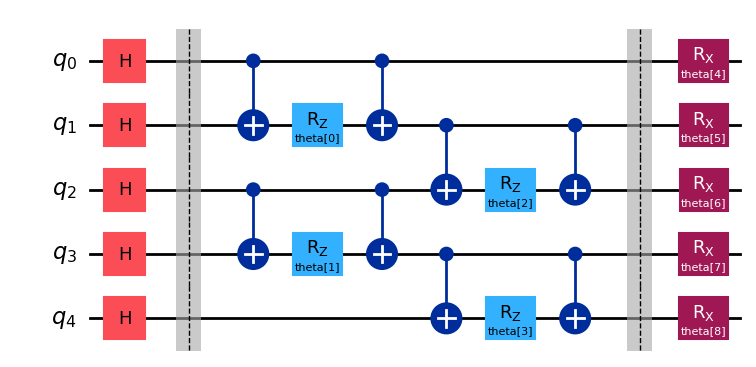

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

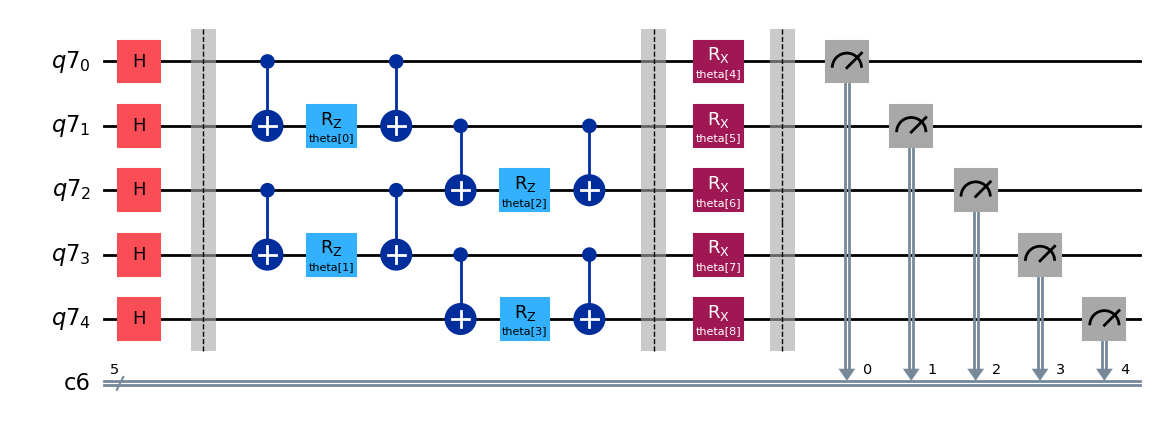

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

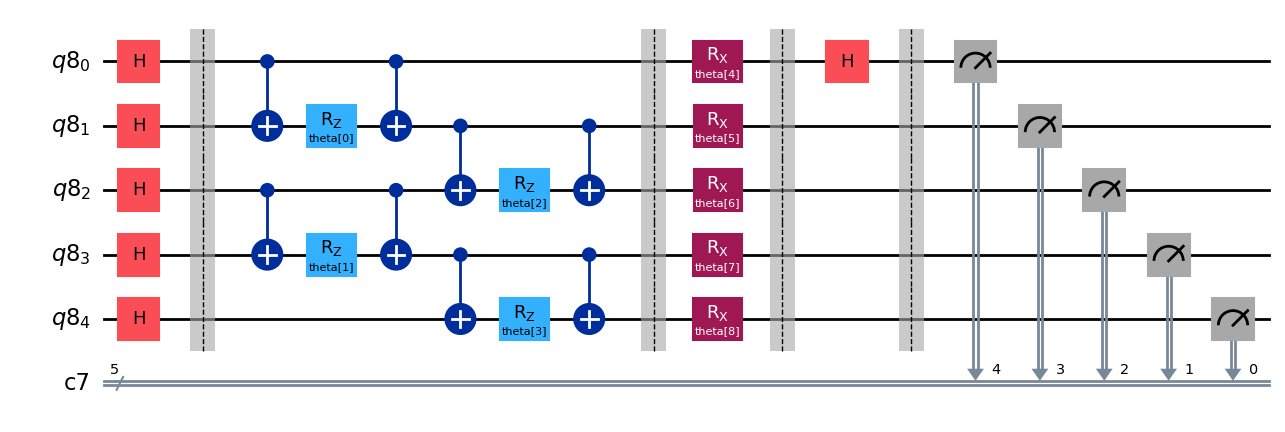

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

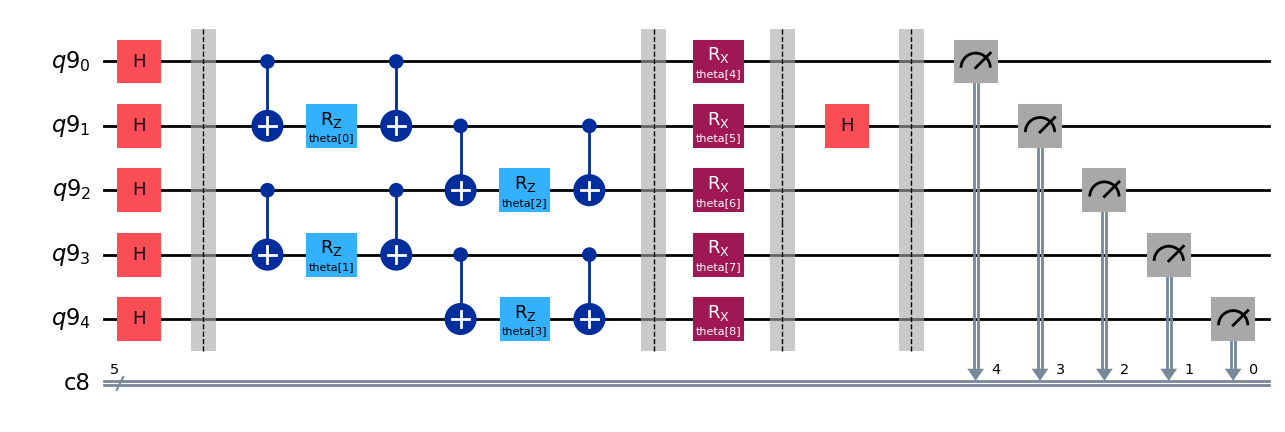

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

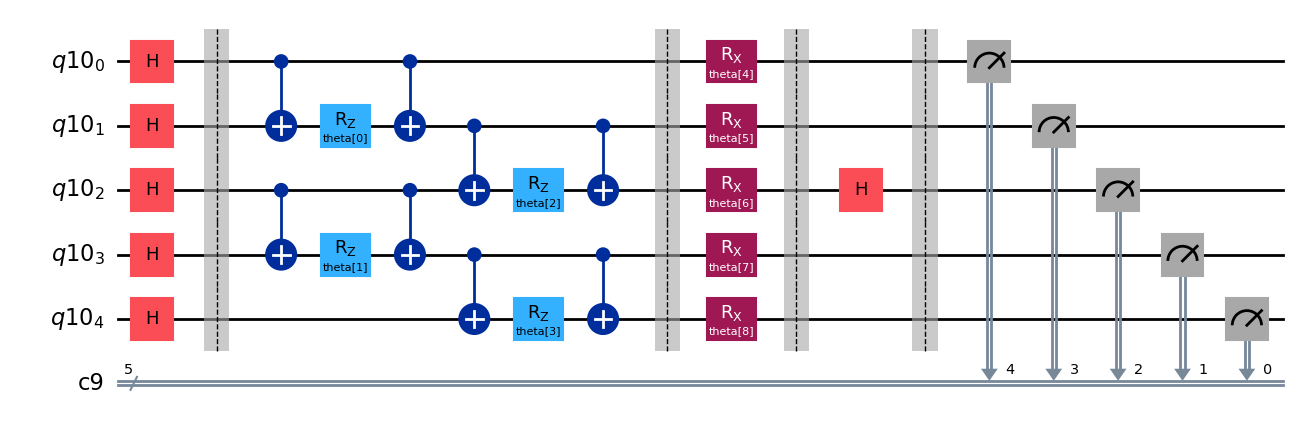

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

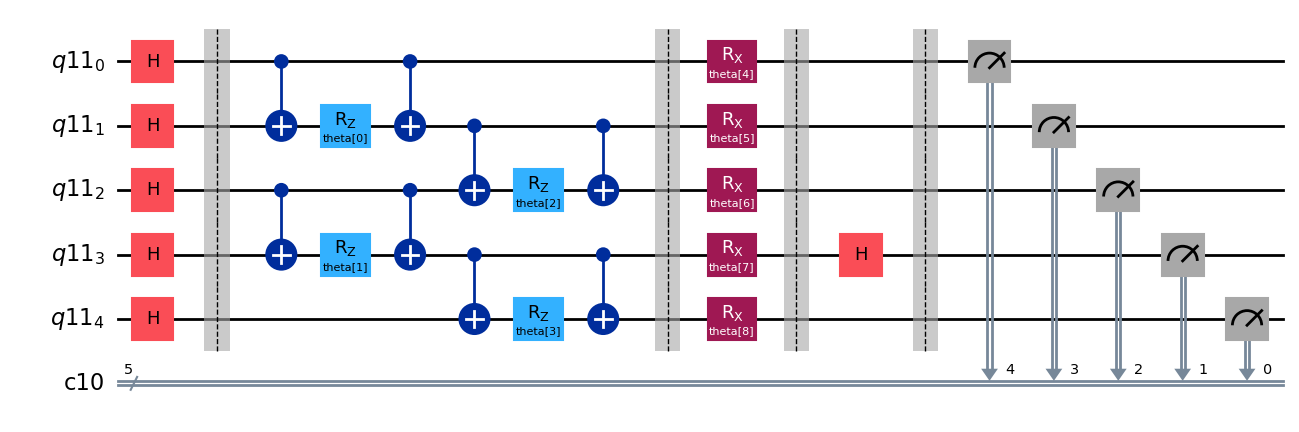

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

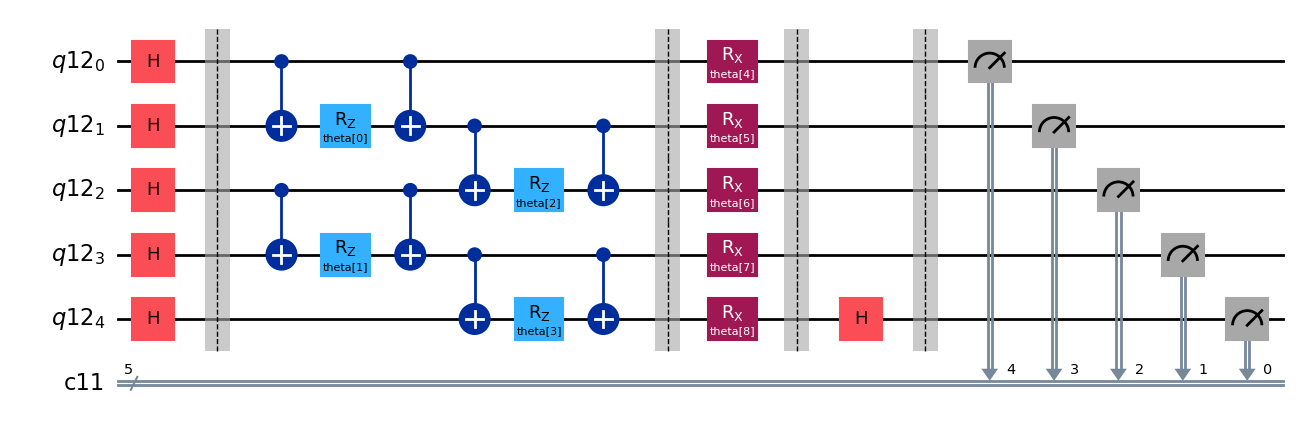

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:25]
  W2 = parameter[25:50]
  W3 = parameter[50:75]
  c = parameter[75]

  W1 = W1.reshape(5,5)
  W2 = W2.reshape(5,5)
  W3 = W3.reshape(5,5)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  z2 = relu(a2)

  a3 = np.matmul(W3, z2)
  y = output_activate(c, a3)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=100000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1]

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  bitflip_prob = error_list[num]

  bit1 = pauli_error([('X', bitflip_prob), ('I', 1 - bitflip_prob)])
  bit2 = bit1.tensor(bit1)

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(bit1, ["u1", "u2", "u3"])
  noise_model.add_all_qubit_quantum_error(bit2, ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=76), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=76), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(bitflip_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

error rate : 0.0, lowest energy vqe : -5.876600000000001

error rate : 0.001, lowest energy vqe : -5.878239999999999

error rate : 0.002, lowest energy vqe : -5.87098

error rate : 0.003, lowest energy vqe : -5.860439999999999

error rate : 0.004, lowest energy vqe : -5.8485000000000005

error rate : 0.005, lowest energy vqe : -5.8170600000000015

error rate : 0.006, lowest energy vqe : -5.824020000000002

error rate : 0.007, lowest energy vqe : -5.820760000000001

error rate : 0.008, lowest energy vqe : -5.8051200000000005

error rate : 0.009000000000000001, lowest energy vqe : -5.798660000000001

error rate : 0.01, lowest energy vqe : -5.77824

error rate : 0.02, lowest energy vqe : -5.684420000000001

error rate : 0.03, lowest energy vqe : -5.59114

error rate : 0.04, lowest energy vqe : -5.51376

error rate : 0.05, lowest energy vqe : -5.46274

error rate : 0.06, lowest energy vqe : -5.3962200000000005

error rate : 0.07, lowest energy vqe : -5.35034

error rate : 0.08, lowest ener

In [ ]:
lowest_energy_vqe_list

[-5.876600000000001,
 -5.878239999999999,
 -5.87098,
 -5.860439999999999,
 -5.8485000000000005,
 -5.8170600000000015,
 -5.824020000000002,
 -5.820760000000001,
 -5.8051200000000005,
 -5.798660000000001,
 -5.77824,
 -5.684420000000001,
 -5.59114,
 -5.51376,
 -5.46274,
 -5.3962200000000005,
 -5.35034,
 -5.310279999999999,
 -5.273199999999999,
 -5.24208]

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  bitflip_prob = error_list[num]

  bit1 = pauli_error([('X', bitflip_prob), ('I', 1 - bitflip_prob)])
  bit2 = bit1.tensor(bit1)

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(bit1, ["u1", "u2", "u3"])
  noise_model.add_all_qubit_quantum_error(bit2, ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=76), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=76), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(bitflip_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+20, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(76) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 200
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if local_minimum_dict[-1] < lowest_energy_vqnhe:
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(bitflip_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

error rate : 0.0, lowest energy vqe : -5.876600000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.016791
         Iterations: 152
         Function evaluations: 15566
         Gradient evaluations: 202
Optimization terminated successfully.
         Current function value: -5.909072
         Iterations: 150
         Function evaluations: 17710
         Gradient evaluations: 230


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.999245
         Iterations: 150
         Function evaluations: 23959
         Gradient evaluations: 311


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.999152
         Iterations: 200
         Function evaluations: 17787
         Gradient evaluations: 231
         Current function value: -6.012535
         Iterations: 200
         Function evaluations: 18095
         Gradient evaluations: 235
Optimization terminated successfully.
         Current function value: -5.966310
         Iterations: 99
         Function evaluations: 8239
         Gradient evaluations: 107
         Current function value: -6.012567
         Iterations: 200
         Function evaluations: 16709
         Gradient evaluations: 217


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.017490
         Iterations: 170
         Function evaluations: 20493
         Gradient evaluations: 266


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.983556
         Iterations: 128
         Function evaluations: 19647
         Gradient evaluations: 255


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.991777
         Iterations: 73
         Function evaluations: 13872
         Gradient evaluations: 180


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.015182
         Iterations: 200
         Function evaluations: 17171
         Gradient evaluations: 223
         Current function value: -6.013062
         Iterations: 200
         Function evaluations: 19173
         Gradient evaluations: 249
         Current function value: -6.009123
         Iterations: 200
         Function evaluations: 17864
         Gradient evaluations: 232


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.018200
         Iterations: 156
         Function evaluations: 19570
         Gradient evaluations: 254


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.017356
         Iterations: 200
         Function evaluations: 17864
         Gradient evaluations: 232


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.882379
         Iterations: 41
         Function evaluations: 13333
         Gradient evaluations: 173
Optimization terminated successfully.
         Current function value: -5.964127
         Iterations: 81
         Function evaluations: 7777
         Gradient evaluations: 101


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.010874
         Iterations: 200
         Function evaluations: 24640
         Gradient evaluations: 320
         Current function value: -6.018952
         Iterations: 200
         Function evaluations: 20174
         Gradient evaluations: 262


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.005969
         Iterations: 106
         Function evaluations: 12247
         Gradient evaluations: 159
error rate : 0.0, lowest energy vqnhe : -6.0189520440435835



error rate : 0.001, lowest energy vqe : -5.878239999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.015775
         Iterations: 124
         Function evaluations: 18800
         Gradient evaluations: 244


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.929380
         Iterations: 170
         Function evaluations: 30735
         Gradient evaluations: 399


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.016078
         Iterations: 120
         Function evaluations: 17103
         Gradient evaluations: 222


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.965476
         Iterations: 200
         Function evaluations: 21175
         Gradient evaluations: 275
         Current function value: -6.017927
         Iterations: 200
         Function evaluations: 20559
         Gradient evaluations: 267
         Current function value: -5.989152
         Iterations: 200
         Function evaluations: 20559
         Gradient evaluations: 267
Optimization terminated successfully.
         Current function value: -5.990694
         Iterations: 120
         Function evaluations: 10087
         Gradient evaluations: 131
         Current function value: -5.983541
         Iterations: 200
         Function evaluations: 23716
         Gradient evaluations: 308
Optimization terminated successfully.
         Current function value: -5.965726
         Iterations: 128
         Function evaluations: 11165
         Gradient evaluations: 145
         Current function value: -6.005049
         Iterations: 200
         Functio

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.012377
         Iterations: 89
         Function evaluations: 12710
         Gradient evaluations: 165


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.020318
         Iterations: 200
         Function evaluations: 17479
         Gradient evaluations: 227
         Current function value: -6.022635
         Iterations: 200
         Function evaluations: 16863
         Gradient evaluations: 219
         Current function value: -6.012324
         Iterations: 200
         Function evaluations: 20713
         Gradient evaluations: 269
         Current function value: -6.017240
         Iterations: 200
         Function evaluations: 17633
         Gradient evaluations: 229


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.996923
         Iterations: 174
         Function evaluations: 17100
         Gradient evaluations: 222


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.017586
         Iterations: 200
         Function evaluations: 18480
         Gradient evaluations: 240


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.019939
         Iterations: 159
         Function evaluations: 21417
         Gradient evaluations: 278


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.025277
         Iterations: 200
         Function evaluations: 18942
         Gradient evaluations: 246
Optimization terminated successfully.
         Current function value: -5.881671
         Iterations: 15
         Function evaluations: 1309
         Gradient evaluations: 17
error rate : 0.001, lowest energy vqnhe : -6.025276879695588



error rate : 0.002, lowest energy vqe : -5.87098

         Current function value: -6.017345
         Iterations: 200
         Function evaluations: 19327
         Gradient evaluations: 251


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.971823
         Iterations: 164
         Function evaluations: 24651
         Gradient evaluations: 320
Optimization terminated successfully.
         Current function value: -5.941396
         Iterations: 93
         Function evaluations: 12936
         Gradient evaluations: 168


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.013426
         Iterations: 200
         Function evaluations: 20790
         Gradient evaluations: 270


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.936939
         Iterations: 27
         Function evaluations: 6634
         Gradient evaluations: 86


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.010333
         Iterations: 168
         Function evaluations: 21106
         Gradient evaluations: 274


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.004317
         Iterations: 200
         Function evaluations: 23023
         Gradient evaluations: 299
         Current function value: -6.009209
         Iterations: 200
         Function evaluations: 18326
         Gradient evaluations: 238


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.010119
         Iterations: 198
         Function evaluations: 21802
         Gradient evaluations: 283


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.017540
         Iterations: 200
         Function evaluations: 16632
         Gradient evaluations: 216
         Current function value: -6.015695
         Iterations: 200
         Function evaluations: 16863
         Gradient evaluations: 219


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.017289
         Iterations: 190
         Function evaluations: 21719
         Gradient evaluations: 282


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.003675
         Iterations: 200
         Function evaluations: 22253
         Gradient evaluations: 289


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.983527
         Iterations: 95
         Function evaluations: 16567
         Gradient evaluations: 215


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.948418
         Iterations: 97
         Function evaluations: 22737
         Gradient evaluations: 295


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.978809
         Iterations: 155
         Function evaluations: 17258
         Gradient evaluations: 224


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.015747
         Iterations: 200
         Function evaluations: 16786
         Gradient evaluations: 218
         Current function value: -6.015733
         Iterations: 200
         Function evaluations: 17094
         Gradient evaluations: 222


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.000905
         Iterations: 189
         Function evaluations: 22958
         Gradient evaluations: 298
Optimization terminated successfully.
         Current function value: -5.977017
         Iterations: 91
         Function evaluations: 8701
         Gradient evaluations: 113
error rate : 0.002, lowest energy vqnhe : -6.017540376983513



error rate : 0.003, lowest energy vqe : -5.860439999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.005572
         Iterations: 200
         Function evaluations: 22561
         Gradient evaluations: 293
Optimization terminated successfully.
         Current function value: -5.907170
         Iterations: 97
         Function evaluations: 9779
         Gradient evaluations: 127


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.007238
         Iterations: 127
         Function evaluations: 17029
         Gradient evaluations: 221


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.958204
         Iterations: 177
         Function evaluations: 23266
         Gradient evaluations: 302


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.012357
         Iterations: 81
         Function evaluations: 11478
         Gradient evaluations: 149


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.004026
         Iterations: 200
         Function evaluations: 18403
         Gradient evaluations: 239
         Current function value: -5.958939
         Iterations: 200
         Function evaluations: 23023
         Gradient evaluations: 299
         Current function value: -5.957260
         Iterations: 200
         Function evaluations: 17633
         Gradient evaluations: 229


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.004788
         Iterations: 194
         Function evaluations: 22492
         Gradient evaluations: 292


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.987238
         Iterations: 67
         Function evaluations: 12097
         Gradient evaluations: 157


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.012523
         Iterations: 200
         Function evaluations: 21791
         Gradient evaluations: 283
         Current function value: -6.011610
         Iterations: 200
         Function evaluations: 19250
         Gradient evaluations: 250
         Current function value: -5.982220
         Iterations: 200
         Function evaluations: 25641
         Gradient evaluations: 333


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.013383
         Iterations: 183
         Function evaluations: 20874
         Gradient evaluations: 271


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.913107
         Iterations: 144
         Function evaluations: 20876
         Gradient evaluations: 271


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.014097
         Iterations: 200
         Function evaluations: 18172
         Gradient evaluations: 236
         Current function value: -6.014952
         Iterations: 200
         Function evaluations: 20174
         Gradient evaluations: 262
Optimization terminated successfully.
         Current function value: -5.996670
         Iterations: 180
         Function evaluations: 17479
         Gradient evaluations: 227


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.953719
         Iterations: 64
         Function evaluations: 11400
         Gradient evaluations: 148


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.978275
         Iterations: 200
         Function evaluations: 17479
         Gradient evaluations: 227
error rate : 0.003, lowest energy vqnhe : -6.014952170842069



error rate : 0.004, lowest energy vqe : -5.8485000000000005

         Current function value: -6.002240
         Iterations: 200
         Function evaluations: 17017
         Gradient evaluations: 221


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.974637
         Iterations: 160
         Function evaluations: 18332
         Gradient evaluations: 238


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.001796
         Iterations: 200
         Function evaluations: 20251
         Gradient evaluations: 263
         Current function value: -5.994032
         Iterations: 200
         Function evaluations: 22407
         Gradient evaluations: 291


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.997547
         Iterations: 168
         Function evaluations: 21263
         Gradient evaluations: 276


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.987857
         Iterations: 47
         Function evaluations: 8020
         Gradient evaluations: 104


KeyboardInterrupt: 

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(4,20,1):

  noise_model = NoiseModel()
  bitflip_prob = error_list[num]

  bit1 = pauli_error([('X', bitflip_prob), ('I', 1 - bitflip_prob)])
  bit2 = bit1.tensor(bit1)

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(bit1, ["u1", "u2", "u3"])
  noise_model.add_all_qubit_quantum_error(bit2, ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=76), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=76), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(bitflip_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+20, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(76) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 200
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if local_minimum_dict[-1] < lowest_energy_vqnhe:
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(bitflip_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

error rate : 0.004, lowest energy vqe : -5.8485000000000005



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.002240
         Iterations: 200
         Function evaluations: 17017
         Gradient evaluations: 221


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.974637
         Iterations: 160
         Function evaluations: 18332
         Gradient evaluations: 238


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.001796
         Iterations: 200
         Function evaluations: 20251
         Gradient evaluations: 263
         Current function value: -5.994032
         Iterations: 200
         Function evaluations: 22407
         Gradient evaluations: 291


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.997547
         Iterations: 168
         Function evaluations: 21263
         Gradient evaluations: 276


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.987857
         Iterations: 47
         Function evaluations: 8020
         Gradient evaluations: 104
Optimization terminated successfully.
         Current function value: -5.893454
         Iterations: 126
         Function evaluations: 11781
         Gradient evaluations: 153


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.998902
         Iterations: 200
         Function evaluations: 17017
         Gradient evaluations: 221
         Current function value: -6.002061
         Iterations: 200
         Function evaluations: 16170
         Gradient evaluations: 210
         Current function value: -5.997589
         Iterations: 200
         Function evaluations: 18557
         Gradient evaluations: 241


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.943079
         Iterations: 46
         Function evaluations: 6862
         Gradient evaluations: 89


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.000830
         Iterations: 200
         Function evaluations: 17941
         Gradient evaluations: 233
         Current function value: -5.997485
         Iterations: 200
         Function evaluations: 19250
         Gradient evaluations: 250
Optimization terminated successfully.
         Current function value: -5.904292
         Iterations: 133
         Function evaluations: 11781
         Gradient evaluations: 153


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.985714
         Iterations: 174
         Function evaluations: 23035
         Gradient evaluations: 299


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.999341
         Iterations: 200
         Function evaluations: 20636
         Gradient evaluations: 268


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.983222
         Iterations: 97
         Function evaluations: 14789
         Gradient evaluations: 192


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.997663
         Iterations: 200
         Function evaluations: 17941
         Gradient evaluations: 233
         Current function value: -6.001303
         Iterations: 200
         Function evaluations: 17017
         Gradient evaluations: 221


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.964127
         Iterations: 150
         Function evaluations: 17258
         Gradient evaluations: 224
error rate : 0.004, lowest energy vqnhe : -6.002240107988951



error rate : 0.005, lowest energy vqe : -5.8170600000000015



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.984619
         Iterations: 116
         Function evaluations: 15643
         Gradient evaluations: 203


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.985136
         Iterations: 200
         Function evaluations: 18634
         Gradient evaluations: 242
         Current function value: -5.983795
         Iterations: 200
         Function evaluations: 18326
         Gradient evaluations: 238


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.976905
         Iterations: 91
         Function evaluations: 10863
         Gradient evaluations: 141


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.974823
         Iterations: 79
         Function evaluations: 14334
         Gradient evaluations: 186


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.972548
         Iterations: 200
         Function evaluations: 24717
         Gradient evaluations: 321


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.973042
         Iterations: 140
         Function evaluations: 22417
         Gradient evaluations: 291


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.979719
         Iterations: 200
         Function evaluations: 20944
         Gradient evaluations: 272


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.981180
         Iterations: 95
         Function evaluations: 10631
         Gradient evaluations: 138


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.933724
         Iterations: 82
         Function evaluations: 11402
         Gradient evaluations: 148


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.980030
         Iterations: 200
         Function evaluations: 18018
         Gradient evaluations: 234


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.982532
         Iterations: 198
         Function evaluations: 23727
         Gradient evaluations: 308


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.981697
         Iterations: 200
         Function evaluations: 17325
         Gradient evaluations: 225
         Current function value: -5.975054
         Iterations: 200
         Function evaluations: 18249
         Gradient evaluations: 237


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.978401
         Iterations: 159
         Function evaluations: 19339
         Gradient evaluations: 251


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.978520
         Iterations: 200
         Function evaluations: 19019
         Gradient evaluations: 247
Optimization terminated successfully.
         Current function value: -5.978761
         Iterations: 116
         Function evaluations: 9625
         Gradient evaluations: 125


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.934995
         Iterations: 74
         Function evaluations: 11481
         Gradient evaluations: 149


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.933498
         Iterations: 46
         Function evaluations: 11252
         Gradient evaluations: 146


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.986226
         Iterations: 200
         Function evaluations: 18249
         Gradient evaluations: 237
error rate : 0.005, lowest energy vqnhe : -5.986225585629192



error rate : 0.006, lowest energy vqe : -5.824020000000002



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.942504
         Iterations: 88
         Function evaluations: 12941
         Gradient evaluations: 168


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.974846
         Iterations: 163
         Function evaluations: 21417
         Gradient evaluations: 278


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.974753
         Iterations: 200
         Function evaluations: 17094
         Gradient evaluations: 222


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.911515
         Iterations: 88
         Function evaluations: 13561
         Gradient evaluations: 176
Optimization terminated successfully.
         Current function value: -5.864988
         Iterations: 42
         Function evaluations: 3850
         Gradient evaluations: 50


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.981081
         Iterations: 200
         Function evaluations: 22638
         Gradient evaluations: 294


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.979398
         Iterations: 131
         Function evaluations: 17260
         Gradient evaluations: 224


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.965616
         Iterations: 176
         Function evaluations: 22644
         Gradient evaluations: 294
Optimization terminated successfully.
         Current function value: -5.955415
         Iterations: 162
         Function evaluations: 14707
         Gradient evaluations: 191


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.983868
         Iterations: 200
         Function evaluations: 22715
         Gradient evaluations: 295
         Current function value: -5.976885
         Iterations: 200
         Function evaluations: 17787
         Gradient evaluations: 231
         Current function value: -5.980167
         Iterations: 200
         Function evaluations: 17864
         Gradient evaluations: 232
         Current function value: -5.982133
         Iterations: 200
         Function evaluations: 18865
         Gradient evaluations: 245
         Current function value: -5.976319
         Iterations: 200
         Function evaluations: 20944
         Gradient evaluations: 272
         Current function value: -5.975983
         Iterations: 200
         Function evaluations: 17248
         Gradient evaluations: 224


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.967685
         Iterations: 186
         Function evaluations: 22188
         Gradient evaluations: 288


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.968336
         Iterations: 200
         Function evaluations: 25179
         Gradient evaluations: 327


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.872787
         Iterations: 112
         Function evaluations: 15793
         Gradient evaluations: 205


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.870378
         Iterations: 200
         Function evaluations: 20713
         Gradient evaluations: 269
         Current function value: -5.983282
         Iterations: 200
         Function evaluations: 21483
         Gradient evaluations: 279
error rate : 0.006, lowest energy vqnhe : -5.983867787700747



error rate : 0.007, lowest energy vqe : -5.820760000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.990590
         Iterations: 147
         Function evaluations: 17876
         Gradient evaluations: 232


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.995329
         Iterations: 106
         Function evaluations: 13949
         Gradient evaluations: 181


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.973798
         Iterations: 63
         Function evaluations: 12094
         Gradient evaluations: 157


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.995072
         Iterations: 200
         Function evaluations: 19404
         Gradient evaluations: 252


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.991368
         Iterations: 157
         Function evaluations: 17100
         Gradient evaluations: 222


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.953750
         Iterations: 200
         Function evaluations: 22176
         Gradient evaluations: 288
         Current function value: -5.991159
         Iterations: 200
         Function evaluations: 18942
         Gradient evaluations: 246
         Current function value: -5.993255
         Iterations: 200
         Function evaluations: 17941
         Gradient evaluations: 233


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.944028
         Iterations: 167
         Function evaluations: 16947
         Gradient evaluations: 220


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.990829
         Iterations: 200
         Function evaluations: 20174
         Gradient evaluations: 262
         Current function value: -5.996152
         Iterations: 200
         Function evaluations: 18172
         Gradient evaluations: 236
         Current function value: -5.991328
         Iterations: 200
         Function evaluations: 18095
         Gradient evaluations: 235


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.995718
         Iterations: 182
         Function evaluations: 24113
         Gradient evaluations: 313


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.985847
         Iterations: 200
         Function evaluations: 16555
         Gradient evaluations: 215


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.931397
         Iterations: 117
         Function evaluations: 19493
         Gradient evaluations: 253


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.820760
         Iterations: 6
         Function evaluations: 5474
         Gradient evaluations: 71


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.997422
         Iterations: 200
         Function evaluations: 20097
         Gradient evaluations: 261
         Current function value: -5.993963
         Iterations: 200
         Function evaluations: 16863
         Gradient evaluations: 219
         Current function value: -5.987722
         Iterations: 200
         Function evaluations: 18018
         Gradient evaluations: 234
         Current function value: -5.994815
         Iterations: 200
         Function evaluations: 23254
         Gradient evaluations: 302
error rate : 0.007, lowest energy vqnhe : -5.99742223147011



error rate : 0.008, lowest energy vqe : -5.8051200000000005

         Current function value: -5.949137
         Iterations: 200
         Function evaluations: 25179
         Gradient evaluations: 327
         Current function value: -5.970591
         Iterations: 200
         Function evaluations: 18249
         Gradient evaluations: 237
         Current function value: -5.

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.971231
         Iterations: 102
         Function evaluations: 12634
         Gradient evaluations: 164


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.968819
         Iterations: 200
         Function evaluations: 20097
         Gradient evaluations: 261


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.969067
         Iterations: 184
         Function evaluations: 22335
         Gradient evaluations: 290


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.977475
         Iterations: 200
         Function evaluations: 18865
         Gradient evaluations: 245
         Current function value: -5.972394
         Iterations: 200
         Function evaluations: 18634
         Gradient evaluations: 242


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.928383
         Iterations: 135
         Function evaluations: 18337
         Gradient evaluations: 238


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.976096
         Iterations: 151
         Function evaluations: 18800
         Gradient evaluations: 244


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.945158
         Iterations: 188
         Function evaluations: 26570
         Gradient evaluations: 345


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.855617
         Iterations: 113
         Function evaluations: 16026
         Gradient evaluations: 208


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.934278
         Iterations: 52
         Function evaluations: 9707
         Gradient evaluations: 126


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.957968
         Iterations: 200
         Function evaluations: 21329
         Gradient evaluations: 277
error rate : 0.008, lowest energy vqnhe : -5.9779223541247335



error rate : 0.009000000000000001, lowest energy vqe : -5.798660000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.910993
         Iterations: 100
         Function evaluations: 13172
         Gradient evaluations: 171


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.977117
         Iterations: 200
         Function evaluations: 18018
         Gradient evaluations: 234
         Current function value: -5.957724
         Iterations: 200
         Function evaluations: 21098
         Gradient evaluations: 274


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.976588
         Iterations: 139
         Function evaluations: 18254
         Gradient evaluations: 237


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.979435
         Iterations: 200
         Function evaluations: 17402
         Gradient evaluations: 226
         Current function value: -5.955543
         Iterations: 200
         Function evaluations: 23331
         Gradient evaluations: 303


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.972102
         Iterations: 85
         Function evaluations: 11099
         Gradient evaluations: 144


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.978135
         Iterations: 200
         Function evaluations: 19481
         Gradient evaluations: 253


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.977941
         Iterations: 147
         Function evaluations: 15099
         Gradient evaluations: 196


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.800163
         Iterations: 6
         Function evaluations: 6475
         Gradient evaluations: 84


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.847118
         Iterations: 43
         Function evaluations: 7244
         Gradient evaluations: 94


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.967500
         Iterations: 200
         Function evaluations: 19635
         Gradient evaluations: 255
         Current function value: -5.979512
         Iterations: 200
         Function evaluations: 17710
         Gradient evaluations: 230


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.798669
         Iterations: 4
         Function evaluations: 6778
         Gradient evaluations: 88


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.977028
         Iterations: 200
         Function evaluations: 18788
         Gradient evaluations: 244
         Current function value: -5.969223
         Iterations: 200
         Function evaluations: 19250
         Gradient evaluations: 250
         Current function value: -5.971874
         Iterations: 200
         Function evaluations: 19096
         Gradient evaluations: 248
         Current function value: -5.979215
         Iterations: 200
         Function evaluations: 18326
         Gradient evaluations: 238
         Current function value: -5.978405
         Iterations: 200
         Function evaluations: 17325
         Gradient evaluations: 225
         Current function value: -5.970627
         Iterations: 200
         Function evaluations: 19866
         Gradient evaluations: 258
error rate : 0.009000000000000001, lowest energy vqnhe : -5.9795121319115925



error rate : 0.01, lowest energy vqe : -5.77824

         Current function value

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.965577
         Iterations: 91
         Function evaluations: 15797
         Gradient evaluations: 205


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.947066
         Iterations: 200
         Function evaluations: 19481
         Gradient evaluations: 253
         Current function value: -5.981522
         Iterations: 200
         Function evaluations: 16863
         Gradient evaluations: 219
         Current function value: -5.981392
         Iterations: 200
         Function evaluations: 18634
         Gradient evaluations: 242
         Current function value: -5.983102
         Iterations: 200
         Function evaluations: 19481
         Gradient evaluations: 253
Optimization terminated successfully.
         Current function value: -5.915666
         Iterations: 79
         Function evaluations: 6468
         Gradient evaluations: 84
         Current function value: -5.969038
         Iterations: 200
         Function evaluations: 19943
         Gradient evaluations: 259


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.971736
         Iterations: 143
         Function evaluations: 20879
         Gradient evaluations: 271


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.925929
         Iterations: 75
         Function evaluations: 14950
         Gradient evaluations: 194


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.961167
         Iterations: 105
         Function evaluations: 17331
         Gradient evaluations: 225


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.974895
         Iterations: 134
         Function evaluations: 18104
         Gradient evaluations: 235


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.939228
         Iterations: 119
         Function evaluations: 19568
         Gradient evaluations: 254


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.984475
         Iterations: 200
         Function evaluations: 16709
         Gradient evaluations: 217


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.981803
         Iterations: 94
         Function evaluations: 11864
         Gradient evaluations: 154


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.984240
         Iterations: 200
         Function evaluations: 17017
         Gradient evaluations: 221
Optimization terminated successfully.
         Current function value: -5.894048
         Iterations: 111
         Function evaluations: 11627
         Gradient evaluations: 151
         Current function value: -5.983678
         Iterations: 200
         Function evaluations: 17633
         Gradient evaluations: 229
Optimization terminated successfully.
         Current function value: -5.824464
         Iterations: 47
         Function evaluations: 3696
         Gradient evaluations: 48
error rate : 0.01, lowest energy vqnhe : -5.984474710604308



error rate : 0.02, lowest energy vqe : -5.684420000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.774670
         Iterations: 33
         Function evaluations: 7556
         Gradient evaluations: 98


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.964949
         Iterations: 200
         Function evaluations: 19789
         Gradient evaluations: 257
         Current function value: -5.980128
         Iterations: 200
         Function evaluations: 22715
         Gradient evaluations: 295


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.895312
         Iterations: 194
         Function evaluations: 27270
         Gradient evaluations: 354


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.978312
         Iterations: 157
         Function evaluations: 18257
         Gradient evaluations: 237


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.933808
         Iterations: 42
         Function evaluations: 11181
         Gradient evaluations: 145


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.987356
         Iterations: 200
         Function evaluations: 20636
         Gradient evaluations: 268
         Current function value: -5.981384
         Iterations: 200
         Function evaluations: 22561
         Gradient evaluations: 293
Optimization terminated successfully.
         Current function value: -5.723769
         Iterations: 54
         Function evaluations: 6083
         Gradient evaluations: 79


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.783408
         Iterations: 33
         Function evaluations: 7481
         Gradient evaluations: 97


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.909712
         Iterations: 134
         Function evaluations: 20494
         Gradient evaluations: 266


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.976685
         Iterations: 52
         Function evaluations: 9635
         Gradient evaluations: 125


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.984988
         Iterations: 200
         Function evaluations: 18634
         Gradient evaluations: 242


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.942593
         Iterations: 175
         Function evaluations: 25262
         Gradient evaluations: 328


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.985110
         Iterations: 140
         Function evaluations: 15719
         Gradient evaluations: 204
Optimization terminated successfully.
         Current function value: -5.783867
         Iterations: 77
         Function evaluations: 8085
         Gradient evaluations: 105
Optimization terminated successfully.
         Current function value: -5.772178
         Iterations: 26
         Function evaluations: 3311
         Gradient evaluations: 43


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.988743
         Iterations: 200
         Function evaluations: 19327
         Gradient evaluations: 251


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.971640
         Iterations: 103
         Function evaluations: 12786
         Gradient evaluations: 166


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.980194
         Iterations: 168
         Function evaluations: 19794
         Gradient evaluations: 257
error rate : 0.02, lowest energy vqnhe : -5.988743176942917



error rate : 0.03, lowest energy vqe : -5.59114



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.900390
         Iterations: 93
         Function evaluations: 12018
         Gradient evaluations: 156


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.997495
         Iterations: 128
         Function evaluations: 15176
         Gradient evaluations: 197


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.004631
         Iterations: 164
         Function evaluations: 23256
         Gradient evaluations: 302
Optimization terminated successfully.
         Current function value: -6.001923
         Iterations: 165
         Function evaluations: 16324
         Gradient evaluations: 212


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.902684
         Iterations: 74
         Function evaluations: 10861
         Gradient evaluations: 141


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.735567
         Iterations: 50
         Function evaluations: 9480
         Gradient evaluations: 123
Optimization terminated successfully.
         Current function value: -6.005477
         Iterations: 147
         Function evaluations: 12012
         Gradient evaluations: 156
Optimization terminated successfully.
         Current function value: -5.733990
         Iterations: 51
         Function evaluations: 4081
         Gradient evaluations: 53


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.005173
         Iterations: 200
         Function evaluations: 19019
         Gradient evaluations: 247


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.997040
         Iterations: 98
         Function evaluations: 11478
         Gradient evaluations: 149


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.002007
         Iterations: 200
         Function evaluations: 24717
         Gradient evaluations: 321


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.973480
         Iterations: 188
         Function evaluations: 31274
         Gradient evaluations: 406


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.004923
         Iterations: 184
         Function evaluations: 19878
         Gradient evaluations: 258


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.935492
         Iterations: 164
         Function evaluations: 23107
         Gradient evaluations: 300


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.000820
         Iterations: 200
         Function evaluations: 21329
         Gradient evaluations: 277


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.980624
         Iterations: 133
         Function evaluations: 16253
         Gradient evaluations: 211


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.003222
         Iterations: 200
         Function evaluations: 20944
         Gradient evaluations: 272


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.836002
         Iterations: 99
         Function evaluations: 14482
         Gradient evaluations: 188


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.001540
         Iterations: 200
         Function evaluations: 17248
         Gradient evaluations: 224
Optimization terminated successfully.
         Current function value: -5.735727
         Iterations: 94
         Function evaluations: 11473
         Gradient evaluations: 149
error rate : 0.03, lowest energy vqnhe : -6.005476522671007



error rate : 0.04, lowest energy vqe : -5.51376

         Current function value: -6.040235
         Iterations: 200
         Function evaluations: 22330
         Gradient evaluations: 290
         Current function value: -5.996884
         Iterations: 200
         Function evaluations: 17094
         Gradient evaluations: 222
         Current function value: -6.022446
         Iterations: 200
         Function evaluations: 18634
         Gradient evaluations: 242
Optimization terminated successfully.
         Current function value: -5.713665
         Iterations: 130
         Function evaluations: 13706
        

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.678359
         Iterations: 89
         Function evaluations: 26648
         Gradient evaluations: 346


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.019560
         Iterations: 158
         Function evaluations: 20956
         Gradient evaluations: 272


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.947505
         Iterations: 156
         Function evaluations: 22333
         Gradient evaluations: 290


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.957650
         Iterations: 78
         Function evaluations: 16413
         Gradient evaluations: 213


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.015007
         Iterations: 200
         Function evaluations: 21560
         Gradient evaluations: 280


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.046631
         Iterations: 167
         Function evaluations: 23181
         Gradient evaluations: 301


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.865713
         Iterations: 79
         Function evaluations: 10861
         Gradient evaluations: 141


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.046065
         Iterations: 164
         Function evaluations: 19031
         Gradient evaluations: 247
Optimization terminated successfully.
         Current function value: -5.668339
         Iterations: 113
         Function evaluations: 10164
         Gradient evaluations: 132


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.945842
         Iterations: 200
         Function evaluations: 16709
         Gradient evaluations: 217


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.038384
         Iterations: 176
         Function evaluations: 23029
         Gradient evaluations: 299


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.017252
         Iterations: 200
         Function evaluations: 23485
         Gradient evaluations: 305


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.671618
         Iterations: 39
         Function evaluations: 10484
         Gradient evaluations: 136


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.673774
         Iterations: 42
         Function evaluations: 6172
         Gradient evaluations: 80


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.994909
         Iterations: 200
         Function evaluations: 20482
         Gradient evaluations: 266
error rate : 0.04, lowest energy vqnhe : -6.046631277747858



error rate : 0.05, lowest energy vqe : -5.46274



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.984128
         Iterations: 45
         Function evaluations: 8091
         Gradient evaluations: 105


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.866829
         Iterations: 60
         Function evaluations: 11099
         Gradient evaluations: 144


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.038215
         Iterations: 200
         Function evaluations: 20020
         Gradient evaluations: 260
         Current function value: -6.036791
         Iterations: 200
         Function evaluations: 20867
         Gradient evaluations: 271
         Current function value: -5.999857
         Iterations: 200
         Function evaluations: 23793
         Gradient evaluations: 309
         Current function value: -6.039288
         Iterations: 200
         Function evaluations: 18018
         Gradient evaluations: 234
         Current function value: -6.037518
         Iterations: 200
         Function evaluations: 18942
         Gradient evaluations: 246
         Current function value: -5.939088
         Iterations: 200
         Function evaluations: 17941
         Gradient evaluations: 233
         Current function value: -6.038225
         Iterations: 200
         Function evaluations: 18018
         Gradient evaluations: 234
         Current fun

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.950894
         Iterations: 196
         Function evaluations: 24724
         Gradient evaluations: 321


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.033077
         Iterations: 200
         Function evaluations: 26488
         Gradient evaluations: 344
Optimization terminated successfully.
         Current function value: -5.643370
         Iterations: 63
         Function evaluations: 5159
         Gradient evaluations: 67
         Current function value: -5.925018
         Iterations: 200
         Function evaluations: 19712
         Gradient evaluations: 256
         Current function value: -6.032536
         Iterations: 200
         Function evaluations: 22022
         Gradient evaluations: 286


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.035502
         Iterations: 187
         Function evaluations: 21108
         Gradient evaluations: 274


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.037882
         Iterations: 200
         Function evaluations: 16401
         Gradient evaluations: 213
error rate : 0.05, lowest energy vqnhe : -6.039288130947828



error rate : 0.06, lowest energy vqe : -5.3962200000000005

         Current function value: -6.057260
         Iterations: 200
         Function evaluations: 20713
         Gradient evaluations: 269
         Current function value: -6.047163
         Iterations: 200
         Function evaluations: 17864
         Gradient evaluations: 232


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.968228
         Iterations: 167
         Function evaluations: 26265
         Gradient evaluations: 341


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.951618
         Iterations: 82
         Function evaluations: 13641
         Gradient evaluations: 177


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.925567
         Iterations: 69
         Function evaluations: 12401
         Gradient evaluations: 161


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.950547
         Iterations: 139
         Function evaluations: 16872
         Gradient evaluations: 219
Optimization terminated successfully.
         Current function value: -5.585261
         Iterations: 71
         Function evaluations: 6237
         Gradient evaluations: 81


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.985414
         Iterations: 52
         Function evaluations: 8867
         Gradient evaluations: 115


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.935472
         Iterations: 160
         Function evaluations: 20721
         Gradient evaluations: 269


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.058387
         Iterations: 200
         Function evaluations: 17556
         Gradient evaluations: 228


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.974425
         Iterations: 93
         Function evaluations: 12255
         Gradient evaluations: 159
Optimization terminated successfully.
         Current function value: -5.653304
         Iterations: 146
         Function evaluations: 14399
         Gradient evaluations: 187


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.052720
         Iterations: 38
         Function evaluations: 8013
         Gradient evaluations: 104


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.943638
         Iterations: 148
         Function evaluations: 20102
         Gradient evaluations: 261


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.977060
         Iterations: 87
         Function evaluations: 14710
         Gradient evaluations: 191


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.055764
         Iterations: 200
         Function evaluations: 18095
         Gradient evaluations: 235
         Current function value: -6.048245
         Iterations: 200
         Function evaluations: 17479
         Gradient evaluations: 227
         Current function value: -6.057833
         Iterations: 200
         Function evaluations: 22407
         Gradient evaluations: 291
         Current function value: -5.801833
         Iterations: 200
         Function evaluations: 27566
         Gradient evaluations: 358


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.985773
         Iterations: 171
         Function evaluations: 18792
         Gradient evaluations: 244
error rate : 0.06, lowest energy vqnhe : -6.058387174047984



error rate : 0.07, lowest energy vqe : -5.35034



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.931777
         Iterations: 102
         Function evaluations: 14097
         Gradient evaluations: 183


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.051368
         Iterations: 143
         Function evaluations: 21726
         Gradient evaluations: 282


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.029467
         Iterations: 200
         Function evaluations: 19866
         Gradient evaluations: 258


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.985528
         Iterations: 61
         Function evaluations: 8942
         Gradient evaluations: 116


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.964865
         Iterations: 117
         Function evaluations: 17953
         Gradient evaluations: 233
Optimization terminated successfully.
         Current function value: -5.788031
         Iterations: 110
         Function evaluations: 11935
         Gradient evaluations: 155


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.115792
         Iterations: 200
         Function evaluations: 22099
         Gradient evaluations: 287
         Current function value: -6.120011
         Iterations: 200
         Function evaluations: 23254
         Gradient evaluations: 302


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.117131
         Iterations: 122
         Function evaluations: 20032
         Gradient evaluations: 260


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.053296
         Iterations: 80
         Function evaluations: 11170
         Gradient evaluations: 145


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.082729
         Iterations: 200
         Function evaluations: 20636
         Gradient evaluations: 268


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.029124
         Iterations: 135
         Function evaluations: 15642
         Gradient evaluations: 203


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.116815
         Iterations: 141
         Function evaluations: 17945
         Gradient evaluations: 233


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.116845
         Iterations: 121
         Function evaluations: 20263
         Gradient evaluations: 263


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.116901
         Iterations: 55
         Function evaluations: 9945
         Gradient evaluations: 129


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.995476
         Iterations: 200
         Function evaluations: 19481
         Gradient evaluations: 253
         Current function value: -5.948001
         Iterations: 200
         Function evaluations: 27027
         Gradient evaluations: 351
         Current function value: -6.121890
         Iterations: 200
         Function evaluations: 21560
         Gradient evaluations: 280


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.019591
         Iterations: 34
         Function evaluations: 9175
         Gradient evaluations: 119


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.027729
         Iterations: 118
         Function evaluations: 14943
         Gradient evaluations: 194
error rate : 0.07, lowest energy vqnhe : -6.121890142835836



error rate : 0.08, lowest energy vqe : -5.310279999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.151500
         Iterations: 158
         Function evaluations: 17868
         Gradient evaluations: 232


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.145739
         Iterations: 200
         Function evaluations: 19019
         Gradient evaluations: 247
Optimization terminated successfully.
         Current function value: -5.548891
         Iterations: 111
         Function evaluations: 12166
         Gradient evaluations: 158


In [ ]:
lowest_energy_vqnhe_list = []

for num in range(17,20,1):

  noise_model = NoiseModel()
  bitflip_prob = error_list[num]

  bit1 = pauli_error([('X', bitflip_prob), ('I', 1 - bitflip_prob)])
  bit2 = bit1.tensor(bit1)

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(bit1, ["u1", "u2", "u3"])
  noise_model.add_all_qubit_quantum_error(bit2, ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=76), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=76), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(bitflip_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+20, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(76) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 200
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if local_minimum_dict[-1] < lowest_energy_vqnhe:
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(bitflip_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

NameError: name 'NoiseModel' is not defined

In [ ]:
lowest_energy_vqnhe_list

## Bit Flip Channel, Error 0.001~0.1, Shots = 100000, CNN ver 1

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


def cnn2(vec, x):
  a = vec[0]
  b = vec[1]

  lst = []
  lst.append(b*x[0])
  lst.append(a*x[0]+b*x[1])
  lst.append(a*x[1]+b*x[2])
  lst.append(a*x[2]+b*x[3])
  lst.append(a*x[3]+b*x[4])
  lst.append(a*x[4])

  lst = np.array(lst)

  return np.max(lst)


def cnn3(vec, x):
  a = vec[0]
  b = vec[1]
  c = vec[2]

  lst = []
  lst.append(c*x[0])
  lst.append(b*x[0]+c*x[1])
  lst.append(a*x[0]+b*x[1]+c*x[2])
  lst.append(a*x[1]+b*x[2]+c*x[3])
  lst.append(a*x[2]+b*x[3]+c*x[4])
  lst.append(a*x[3]+b*x[4])
  lst.append(a*x[4])

  lst = np.array(lst)

  return np.max(lst)


def cnn4(vec, x):
  a = vec[0]
  b = vec[1]
  c = vec[2]
  d = vec[3]

  lst = []
  lst.append(d*x[0])
  lst.append(c*x[0]+d*x[1])
  lst.append(b*x[0]+c*x[1]+d*x[2])
  lst.append(a*x[0]+b*x[1]+c*x[2]+d*x[3])
  lst.append(a*x[1]+b*x[2]+c*x[3]+d*x[4])
  lst.append(a*x[2]+b*x[3]+c*x[4])
  lst.append(a*x[3]+b*x[4])
  lst.append(a*x[4])

  lst = np.array(lst)

  return np.max(lst)


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  a1 = np.array([cnn2(parameter[0:2], x), cnn2(parameter[2:4], x), cnn3(parameter[4:7], x), cnn3(parameter[7:10], x), cnn4(parameter[10:14], x), cnn4(parameter[14:18], x)])
  z1 = relu(a1)

  FC1 = parameter[18:48]
  FC2 = parameter[48:53]
  c = parameter[53]

  FC1 = FC1.reshape(5,6)
  FC2 = FC2.reshape(1,5)


  a2 = np.matmul(FC1, z1)
  z2 = relu(a2)

  a3 = np.matmul(FC2, z2)
  y = output_activate(c, a3)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=100000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  bitflip_prob = error_list[num]

  bit1 = pauli_error([('X', bitflip_prob), ('I', 1 - bitflip_prob)])
  bit2 = bit1.tensor(bit1)

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(bit1, ["u1", "u2", "u3"])
  noise_model.add_all_qubit_quantum_error(bit2, ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=54), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=54), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(bitflip_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

In [ ]:
lowest_energy_vqe_list

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  bitflip_prob = error_list[num]

  bit1 = pauli_error([('X', bitflip_prob), ('I', 1 - bitflip_prob)])
  bit2 = bit1.tensor(bit1)

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(bit1, ["u1", "u2", "u3"])
  noise_model.add_all_qubit_quantum_error(bit2, ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=54), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=54), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(bitflip_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+10, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(54) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 300
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if len(local_minimum_dict) and local_minimum_dict[-1] < lowest_energy_vqnhe :
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(bitflip_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

In [ ]:
lowest_energy_vqnhe_list

## Bit Flip Channel, Error 0.001~0.1, Shots = 100000, CNN ver 2

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


def cnn3(vec, x):
  a = vec[0]
  b = vec[1]
  c = vec[2]

  lst = []
  lst.append(c*x[0])
  lst.append(b*x[0]+c*x[1])
  lst.append(a*x[0]+b*x[1]+c*x[2])
  lst.append(a*x[1]+b*x[2]+c*x[3])
  lst.append(a*x[2]+b*x[3]+c*x[4])
  lst.append(a*x[3]+b*x[4])
  lst.append(a*x[4])

  lst = np.array(lst)

  return np.max(lst)


def cnn5(vec, x):
  a = vec[0]
  b = vec[1]
  c = vec[2]
  d = vec[3]
  e = vec[4]

  lst = []
  lst.append(e*x[0])
  lst.append(d*x[0]+e*x[1])
  lst.append(c*x[0]+d*x[1]+e*x[2])
  lst.append(b*x[0]+c*x[1]+d*x[2]+e*x[3])
  lst.append(a*x[0]+b*x[1]+c*x[2]+d*x[3]+e*x[4])
  lst.append(a*x[1]+b*x[2]+c*x[3]+d*x[4])
  lst.append(a*x[2]+b*x[3]+c*x[4])
  lst.append(a*x[3]+b*x[4])
  lst.append(a*x[4])

  lst = np.array(lst)

  return np.max(lst)


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  a1 = np.array([cnn3(parameter[0:3], x), cnn3(parameter[3:6], x), cnn5(parameter[6:11], x), cnn5(parameter[11:16], x)])
  z1 = relu(a1)

  FC1 = parameter[16:36]
  FC2 = parameter[36:41]
  c = parameter[41]

  FC1 = FC1.reshape(5,4)
  FC2 = FC2.reshape(1,5)


  a2 = np.matmul(FC1, z1)
  z2 = relu(a2)

  a3 = np.matmul(FC2, z2)
  y = output_activate(c, a3)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=100000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  bitflip_prob = error_list[num]

  bit1 = pauli_error([('X', bitflip_prob), ('I', 1 - bitflip_prob)])
  bit2 = bit1.tensor(bit1)

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(bit1, ["u1", "u2", "u3"])
  noise_model.add_all_qubit_quantum_error(bit2, ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=42), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=42), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(bitflip_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

In [ ]:
lowest_energy_vqe_list

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  bitflip_prob = error_list[num]

  bit1 = pauli_error([('X', bitflip_prob), ('I', 1 - bitflip_prob)])
  bit2 = bit1.tensor(bit1)

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(bit1, ["u1", "u2", "u3"])
  noise_model.add_all_qubit_quantum_error(bit2, ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=42), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=42), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(bitflip_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+10, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(42) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 300
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if len(local_minimum_dict) and local_minimum_dict[-1] < lowest_energy_vqnhe :
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(bitflip_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

In [ ]:
lowest_energy_vqnhe_list

## Bit Flip Channel, Error 0.001~0.1, Shots = 100000, CNN ver 3

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

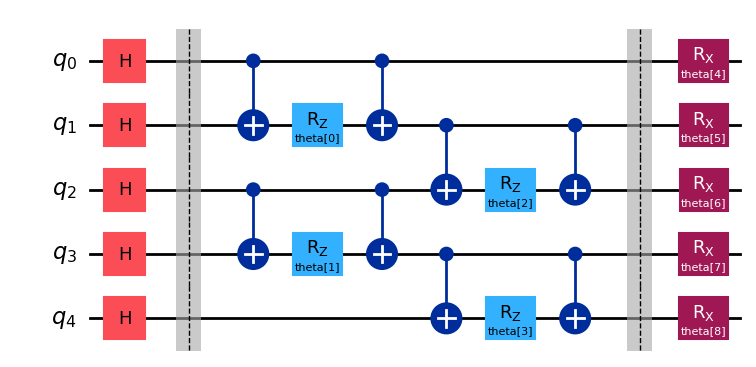

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

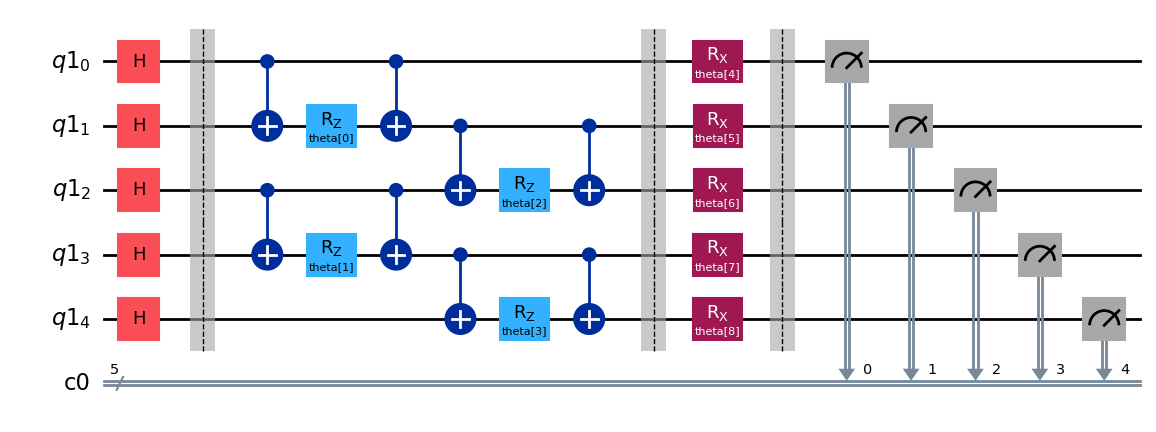

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

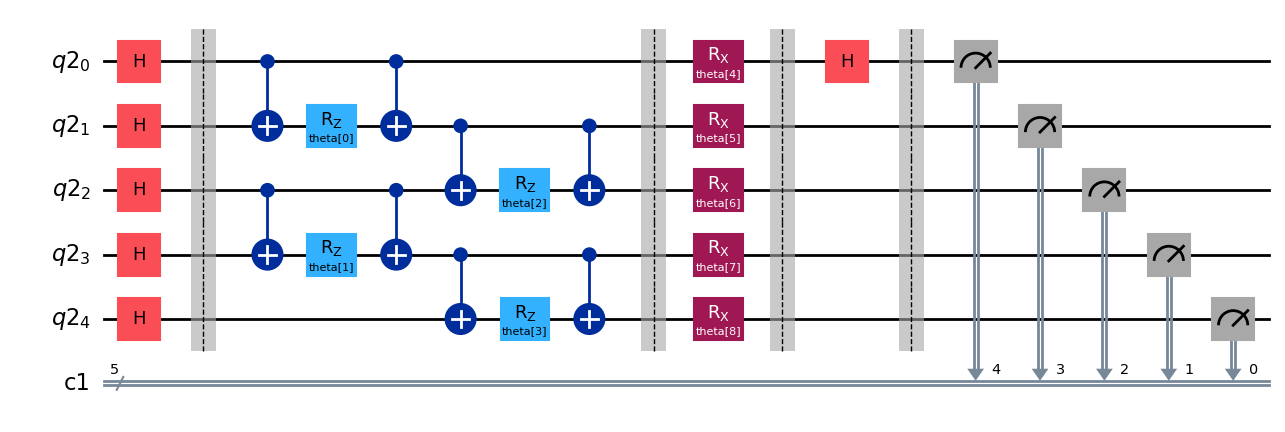

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

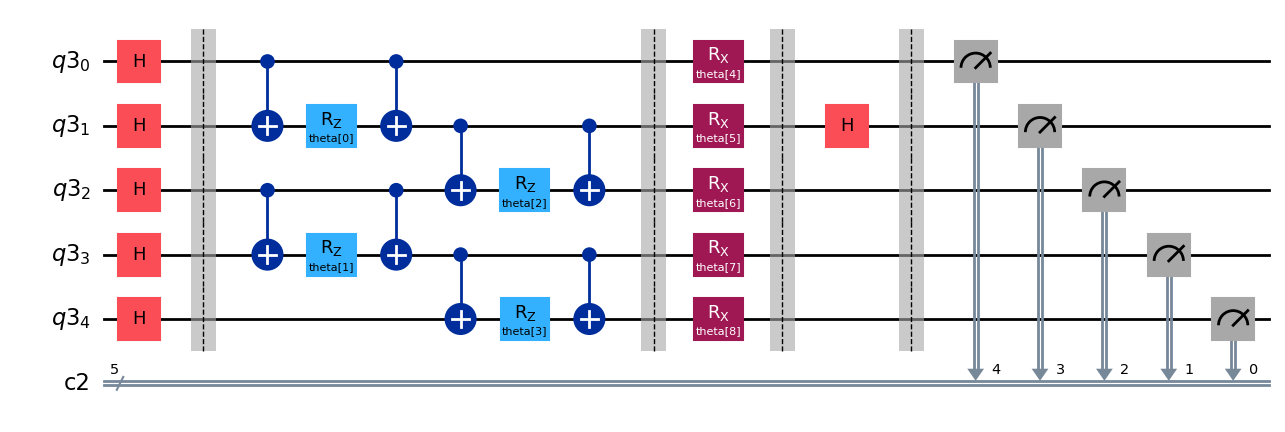

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

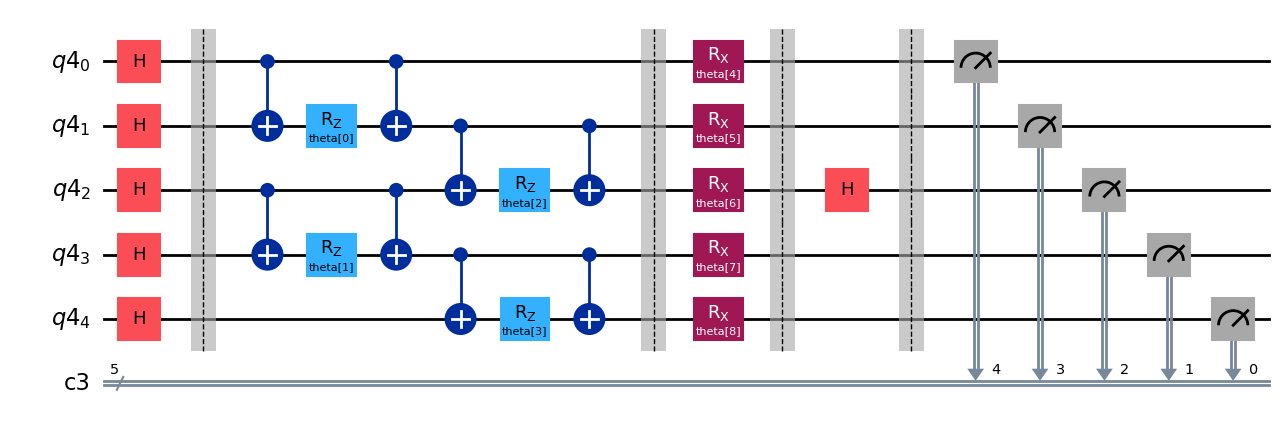

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

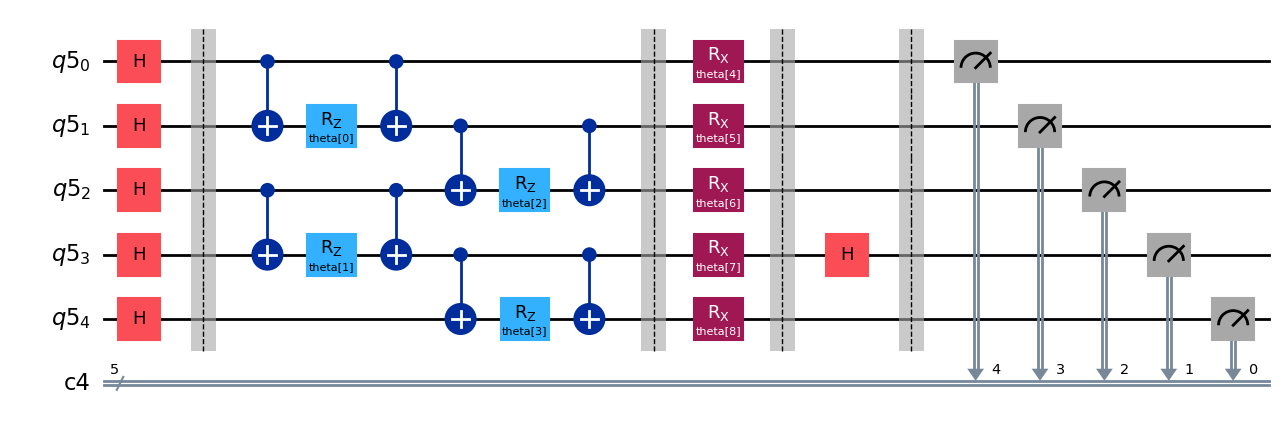

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

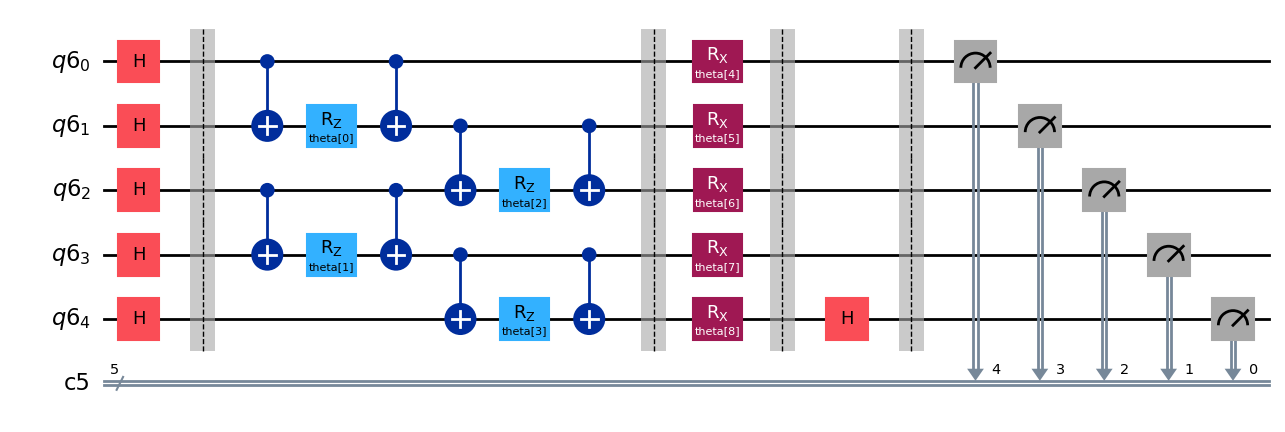

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


def cnn3(vec, x):
  a = vec[0]
  b = vec[1]
  c = vec[2]

  lst = []
  lst.append(c*x[0])
  lst.append(b*x[0]+c*x[1])
  lst.append(a*x[0]+b*x[1]+c*x[2])
  lst.append(a*x[1]+b*x[2]+c*x[3])
  lst.append(a*x[2]+b*x[3]+c*x[4])
  lst.append(a*x[3]+b*x[4])
  lst.append(a*x[4])

  lst = np.array(lst)

  return np.max(lst)


def cnn5(vec, x):
  a = vec[0]
  b = vec[1]
  c = vec[2]
  d = vec[3]
  e = vec[4]

  lst = []
  lst.append(e*x[0])
  lst.append(d*x[0]+e*x[1])
  lst.append(c*x[0]+d*x[1]+e*x[2])
  lst.append(b*x[0]+c*x[1]+d*x[2]+e*x[3])
  lst.append(a*x[0]+b*x[1]+c*x[2]+d*x[3]+e*x[4])
  lst.append(a*x[1]+b*x[2]+c*x[3]+d*x[4])
  lst.append(a*x[2]+b*x[3]+c*x[4])
  lst.append(a*x[3]+b*x[4])
  lst.append(a*x[4])

  lst = np.array(lst)

  return np.max(lst)


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  a1 = np.array([cnn3(parameter[0:3], x), cnn3(parameter[3:6], x), cnn3(parameter[6:9], x), cnn3(parameter[9:12], x), cnn5(parameter[12:17], x), cnn5(parameter[17:22], x)])
  z1 = relu(a1)

  FC1 = parameter[22:52]
  FC2 = parameter[52:57]
  c = parameter[57]

  FC1 = FC1.reshape(5,6)
  FC2 = FC2.reshape(1,5)


  a2 = np.matmul(FC1, z1)
  z2 = relu(a2)

  a3 = np.matmul(FC2, z2)
  y = output_activate(c, a3)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=100000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1]

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  bitflip_prob = error_list[num]

  bit1 = pauli_error([('X', bitflip_prob), ('I', 1 - bitflip_prob)])
  bit2 = bit1.tensor(bit1)

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(bit1, ["u1", "u2", "u3"])
  noise_model.add_all_qubit_quantum_error(bit2, ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=58), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=58), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(bitflip_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

error rate : 0.0, lowest energy vqe : -5.876600000000001

error rate : 0.001, lowest energy vqe : -5.878239999999999

error rate : 0.002, lowest energy vqe : -5.87098

error rate : 0.003, lowest energy vqe : -5.860439999999999

error rate : 0.004, lowest energy vqe : -5.8485000000000005

error rate : 0.005, lowest energy vqe : -5.8170600000000015

error rate : 0.006, lowest energy vqe : -5.824020000000002

error rate : 0.007, lowest energy vqe : -5.820760000000001

error rate : 0.008, lowest energy vqe : -5.8051200000000005

error rate : 0.009000000000000001, lowest energy vqe : -5.798660000000001

error rate : 0.01, lowest energy vqe : -5.77824

error rate : 0.02, lowest energy vqe : -5.684420000000001

error rate : 0.03, lowest energy vqe : -5.59114

error rate : 0.04, lowest energy vqe : -5.51376

error rate : 0.05, lowest energy vqe : -5.46274

error rate : 0.06, lowest energy vqe : -5.3962200000000005

error rate : 0.07, lowest energy vqe : -5.35034

error rate : 0.08, lowest ener

In [ ]:
lowest_energy_vqe_list

[-5.876600000000001,
 -5.878239999999999,
 -5.87098,
 -5.860439999999999,
 -5.8485000000000005,
 -5.8170600000000015,
 -5.824020000000002,
 -5.820760000000001,
 -5.8051200000000005,
 -5.798660000000001,
 -5.77824,
 -5.684420000000001,
 -5.59114,
 -5.51376,
 -5.46274,
 -5.3962200000000005,
 -5.35034,
 -5.310279999999999,
 -5.273199999999999,
 -5.24208]

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  bitflip_prob = error_list[num]

  bit1 = pauli_error([('X', bitflip_prob), ('I', 1 - bitflip_prob)])
  bit2 = bit1.tensor(bit1)

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(bit1, ["u1", "u2", "u3"])
  noise_model.add_all_qubit_quantum_error(bit2, ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=58), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=58), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(bitflip_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+10, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(58) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 300
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if len(local_minimum_dict) and local_minimum_dict[-1] < lowest_energy_vqnhe :
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(bitflip_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

error rate : 0.0, lowest energy vqe : -5.876600000000001

Optimization terminated successfully.
         Current function value: -5.994870
         Iterations: 74
         Function evaluations: 6608
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.951320
         Iterations: 37
         Function evaluations: 7269
         Gradient evaluations: 123
Optimization terminated successfully.
         Current function value: -5.947451
         Iterations: 83
         Function evaluations: 8555
         Gradient evaluations: 145
Optimization terminated successfully.
         Current function value: -5.949427
         Iterations: 34
         Function evaluations: 4543
         Gradient evaluations: 77
Optimization terminated successfully.
         Current function value: -5.985222
         Iterations: 87
         Function evaluations: 6077
         Gradient evaluations: 103


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.887912
         Iterations: 8
         Function evaluations: 3906
         Gradient evaluations: 66


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.986437
         Iterations: 208
         Function evaluations: 22785
         Gradient evaluations: 386
Optimization terminated successfully.
         Current function value: -5.956133
         Iterations: 60
         Function evaluations: 4130
         Gradient evaluations: 70
Optimization terminated successfully.
         Current function value: -5.997238
         Iterations: 189
         Function evaluations: 16638
         Gradient evaluations: 282


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.988673
         Iterations: 43
         Function evaluations: 6206
         Gradient evaluations: 105
error rate : 0.0, lowest energy vqnhe : -5.997237682632864



error rate : 0.001, lowest energy vqe : -5.878239999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.879781
         Iterations: 8
         Function evaluations: 3015
         Gradient evaluations: 51


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.984752
         Iterations: 91
         Function evaluations: 9865
         Gradient evaluations: 167


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.963858
         Iterations: 149
         Function evaluations: 14113
         Gradient evaluations: 239
Optimization terminated successfully.
         Current function value: -5.964789
         Iterations: 42
         Function evaluations: 2714
         Gradient evaluations: 46


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.977781
         Iterations: 36
         Function evaluations: 6084
         Gradient evaluations: 103


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.978317
         Iterations: 63
         Function evaluations: 12159
         Gradient evaluations: 206
Optimization terminated successfully.
         Current function value: -5.967466
         Iterations: 86
         Function evaluations: 5782
         Gradient evaluations: 98


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.980047
         Iterations: 57
         Function evaluations: 6561
         Gradient evaluations: 111


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.985511
         Iterations: 92
         Function evaluations: 9388
         Gradient evaluations: 159
Optimization terminated successfully.
         Current function value: -5.970763
         Iterations: 58
         Function evaluations: 4838
         Gradient evaluations: 82
error rate : 0.001, lowest energy vqnhe : -5.9855112832312045



error rate : 0.002, lowest energy vqe : -5.87098

Optimization terminated successfully.
         Current function value: -5.871621
         Iterations: 10
         Function evaluations: 944
         Gradient evaluations: 16


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.984978
         Iterations: 46
         Function evaluations: 6973
         Gradient evaluations: 118


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.961922
         Iterations: 47
         Function evaluations: 6733
         Gradient evaluations: 114


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.978628
         Iterations: 300
         Function evaluations: 27907
         Gradient evaluations: 473
Optimization terminated successfully.
         Current function value: -5.871622
         Iterations: 13
         Function evaluations: 885
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: -5.871622
         Iterations: 20
         Function evaluations: 1298
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: -5.936539
         Iterations: 17
         Function evaluations: 1770
         Gradient evaluations: 30


<ipython-input-20-942dbc8389c9>:3: RuntimeWarning: overflow encountered in scalar power
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])
<ipython-input-20-942dbc8389c9>:11: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-20-942dbc8389c9>:18: RuntimeWarning: overflow encountered in scalar power
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])
<ipython-input-20-942dbc8389c9>:26: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-20-942dbc8389c9>:33: RuntimeWarning: overflow encountered in scalar power
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])
<ipython-input-20-942dbc8389c9>:41: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-20-942dbc8389c9>:48: RuntimeWarning: overflow encountered in scalar 

         Current function value: nan
         Iterations: 153
         Function evaluations: 19883
         Gradient evaluations: 337
Optimization terminated successfully.
         Current function value: -5.992647
         Iterations: 88
         Function evaluations: 6254
         Gradient evaluations: 106
Optimization terminated successfully.
         Current function value: -5.871621
         Iterations: 12
         Function evaluations: 1121
         Gradient evaluations: 19
error rate : 0.002, lowest energy vqnhe : -5.992646715552373



error rate : 0.003, lowest energy vqe : -5.860439999999999

Optimization terminated successfully.
         Current function value: -5.961356
         Iterations: 94
         Function evaluations: 6844
         Gradient evaluations: 116


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.948783
         Iterations: 37
         Function evaluations: 5845
         Gradient evaluations: 99
Optimization terminated successfully.
         Current function value: -5.947202
         Iterations: 72
         Function evaluations: 4720
         Gradient evaluations: 80
Optimization terminated successfully.
         Current function value: -5.948097
         Iterations: 65
         Function evaluations: 4366
         Gradient evaluations: 74
Optimization terminated successfully.
         Current function value: -5.965515
         Iterations: 46
         Function evaluations: 3422
         Gradient evaluations: 58


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.966830
         Iterations: 126
         Function evaluations: 14700
         Gradient evaluations: 249
Optimization terminated successfully.
         Current function value: -5.860811
         Iterations: 12
         Function evaluations: 1121
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: -5.964198
         Iterations: 47
         Function evaluations: 3068
         Gradient evaluations: 52


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.935911
         Iterations: 27
         Function evaluations: 7564
         Gradient evaluations: 128


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.961722
         Iterations: 29
         Function evaluations: 5617
         Gradient evaluations: 95
error rate : 0.003, lowest energy vqnhe : -5.966829961679886



error rate : 0.004, lowest energy vqe : -5.8485000000000005

Optimization terminated successfully.
         Current function value: -5.959256
         Iterations: 106
         Function evaluations: 7552
         Gradient evaluations: 128
Optimization terminated successfully.
         Current function value: -5.848500
         Iterations: 0
         Function evaluations: 59
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: -5.944833
         Iterations: 104
         Function evaluations: 8614
         Gradient evaluations: 146
Optimization terminated successfully.
         Current function value: -5.934806
         Iterations: 25
         Function evaluations: 1711
         Gradient evaluations: 29
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.848685
         Iterations: 23
         Function evaluations: 4142
         Gradient evaluations: 70


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.954736
         Iterations: 60
         Function evaluations: 8030
         Gradient evaluations: 136


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.958974
         Iterations: 217
         Function evaluations: 21252
         Gradient evaluations: 360
Optimization terminated successfully.
         Current function value: -5.870685
         Iterations: 54
         Function evaluations: 5369
         Gradient evaluations: 91
error rate : 0.004, lowest energy vqnhe : -5.959256240130215



error rate : 0.005, lowest energy vqe : -5.8170600000000015



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.877756
         Iterations: 58
         Function evaluations: 12513
         Gradient evaluations: 212


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.937756
         Iterations: 157
         Function evaluations: 17122
         Gradient evaluations: 290
Optimization terminated successfully.
         Current function value: -5.817060
         Iterations: 3
         Function evaluations: 236
         Gradient evaluations: 4


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.929549
         Iterations: 81
         Function evaluations: 11694
         Gradient evaluations: 198
Optimization terminated successfully.
         Current function value: -5.926674
         Iterations: 107
         Function evaluations: 13098
         Gradient evaluations: 222
Optimization terminated successfully.
         Current function value: -5.886117
         Iterations: 21
         Function evaluations: 1652
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: -5.917258
         Iterations: 24
         Function evaluations: 1652
         Gradient evaluations: 28


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.937203
         Iterations: 100
         Function evaluations: 9924
         Gradient evaluations: 168


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.953058
         Iterations: 206
         Function evaluations: 20658
         Gradient evaluations: 350
Optimization terminated successfully.
         Current function value: -5.925956
         Iterations: 64
         Function evaluations: 4248
         Gradient evaluations: 72
error rate : 0.005, lowest energy vqnhe : -5.953057767459812



error rate : 0.006, lowest energy vqe : -5.824020000000002

Optimization terminated successfully.
         Current function value: -5.898061
         Iterations: 78
         Function evaluations: 5664
         Gradient evaluations: 96
Optimization terminated successfully.
         Current function value: -5.929090
         Iterations: 121
         Function evaluations: 12154
         Gradient evaluations: 206
Optimization terminated successfully.
         Current function value: -5.915173
         Iterations: 63
         Function evaluations: 4602
         Gradient evaluations: 78


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.925839
         Iterations: 134
         Function evaluations: 18944
         Gradient evaluations: 321
Optimization terminated successfully.
         Current function value: -5.916977
         Iterations: 79
         Function evaluations: 7493
         Gradient evaluations: 127


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.897689
         Iterations: 101
         Function evaluations: 12458
         Gradient evaluations: 211
Optimization terminated successfully.
         Current function value: -5.845427
         Iterations: 21
         Function evaluations: 1534
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: -5.941178
         Iterations: 122
         Function evaluations: 9204
         Gradient evaluations: 156


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.922500
         Iterations: 87
         Function evaluations: 9860
         Gradient evaluations: 167


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.921498
         Iterations: 83
         Function evaluations: 7257
         Gradient evaluations: 123
error rate : 0.006, lowest energy vqnhe : -5.941178242788786



error rate : 0.007, lowest energy vqe : -5.820760000000001

Optimization terminated successfully.
         Current function value: -5.923014
         Iterations: 82
         Function evaluations: 5900
         Gradient evaluations: 100
Optimization terminated successfully.
         Current function value: -5.922373
         Iterations: 65
         Function evaluations: 4248
         Gradient evaluations: 72


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.929084
         Iterations: 79
         Function evaluations: 11687
         Gradient evaluations: 198


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.946377
         Iterations: 134
         Function evaluations: 12161
         Gradient evaluations: 206
Optimization terminated successfully.
         Current function value: -5.916906
         Iterations: 85
         Function evaluations: 7552
         Gradient evaluations: 128
Optimization terminated successfully.
         Current function value: -5.911596
         Iterations: 140
         Function evaluations: 15872
         Gradient evaluations: 269


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.898398
         Iterations: 19
         Function evaluations: 6559
         Gradient evaluations: 111


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.932306
         Iterations: 277
         Function evaluations: 23659
         Gradient evaluations: 401


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.917512
         Iterations: 85
         Function evaluations: 9215
         Gradient evaluations: 156
Optimization terminated successfully.
         Current function value: -5.917789
         Iterations: 92
         Function evaluations: 10030
         Gradient evaluations: 170
error rate : 0.007, lowest energy vqnhe : -5.946377093679218



error rate : 0.008, lowest energy vqe : -5.8051200000000005



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.917356
         Iterations: 41
         Function evaluations: 9039
         Gradient evaluations: 153
Optimization terminated successfully.
         Current function value: -5.836987
         Iterations: 48
         Function evaluations: 3245
         Gradient evaluations: 55


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.925547
         Iterations: 83
         Function evaluations: 13047
         Gradient evaluations: 221


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.917997
         Iterations: 105
         Function evaluations: 11691
         Gradient evaluations: 198
Optimization terminated successfully.
         Current function value: -5.805120
         Iterations: 1
         Function evaluations: 118
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: -5.831315
         Iterations: 78
         Function evaluations: 7965
         Gradient evaluations: 135


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.923162
         Iterations: 113
         Function evaluations: 9451
         Gradient evaluations: 160
Optimization terminated successfully.
         Current function value: -5.924079
         Iterations: 162
         Function evaluations: 10974
         Gradient evaluations: 186


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.914020
         Iterations: 49
         Function evaluations: 6207
         Gradient evaluations: 105
Optimization terminated successfully.
         Current function value: -5.866190
         Iterations: 27
         Function evaluations: 1829
         Gradient evaluations: 31
error rate : 0.008, lowest energy vqnhe : -5.92554690791264



error rate : 0.009000000000000001, lowest energy vqe : -5.798660000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.878851
         Iterations: 29
         Function evaluations: 7446
         Gradient evaluations: 126


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.900999
         Iterations: 24
         Function evaluations: 4968
         Gradient evaluations: 84
Optimization terminated successfully.
         Current function value: -5.798660
         Iterations: 1
         Function evaluations: 118
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: -5.900965
         Iterations: 53
         Function evaluations: 4012
         Gradient evaluations: 68


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.915426
         Iterations: 51
         Function evaluations: 7382
         Gradient evaluations: 125


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.908916
         Iterations: 35
         Function evaluations: 4966
         Gradient evaluations: 84
Optimization terminated successfully.
         Current function value: -5.912463
         Iterations: 111
         Function evaluations: 7080
         Gradient evaluations: 120
Optimization terminated successfully.
         Current function value: -5.868762
         Iterations: 26
         Function evaluations: 1593
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: -5.915111
         Iterations: 111
         Function evaluations: 8260
         Gradient evaluations: 140
Optimization terminated successfully.
         Current function value: -5.828903
         Iterations: 44
         Function evaluations: 4484
         Gradient evaluations: 76
error rate : 0.009000000000000001, lowest energy vqnhe : -5.915426092960993



error rate : 0.01, lowest energy vqe : -5.77824



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.903473
         Iterations: 24
         Function evaluations: 6200
         Gradient evaluations: 105
Optimization terminated successfully.
         Current function value: -5.852390
         Iterations: 60
         Function evaluations: 3776
         Gradient evaluations: 64
Optimization terminated successfully.
         Current function value: -5.813514
         Iterations: 27
         Function evaluations: 1652
         Gradient evaluations: 28


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.778656
         Iterations: 23
         Function evaluations: 5263
         Gradient evaluations: 89


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.893214
         Iterations: 43
         Function evaluations: 7087
         Gradient evaluations: 120
Optimization terminated successfully.
         Current function value: -5.860930
         Iterations: 20
         Function evaluations: 2419
         Gradient evaluations: 41


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.905239
         Iterations: 95
         Function evaluations: 9860
         Gradient evaluations: 167
Optimization terminated successfully.
         Current function value: -5.906189
         Iterations: 86
         Function evaluations: 6077
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: -5.915069
         Iterations: 47
         Function evaluations: 3304
         Gradient evaluations: 56
Optimization terminated successfully.
         Current function value: -5.883865
         Iterations: 67
         Function evaluations: 4779
         Gradient evaluations: 81
error rate : 0.01, lowest energy vqnhe : -5.9150689763206445



error rate : 0.02, lowest energy vqe : -5.684420000000001

Optimization terminated successfully.
         Current function value: -5.898995
         Iterations: 56
         Function evaluations: 4838
         Gradient evaluations: 82
Optimization terminated successfully.


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.871890
         Iterations: 284
         Function evaluations: 24721
         Gradient evaluations: 419


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.881232
         Iterations: 57
         Function evaluations: 8979
         Gradient evaluations: 152
Optimization terminated successfully.
         Current function value: -5.876453
         Iterations: 36
         Function evaluations: 2419
         Gradient evaluations: 41


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.826229
         Iterations: 58
         Function evaluations: 6974
         Gradient evaluations: 118


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.875656
         Iterations: 41
         Function evaluations: 8219
         Gradient evaluations: 139


<ipython-input-20-942dbc8389c9>:3: RuntimeWarning: overflow encountered in scalar power
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])
<ipython-input-20-942dbc8389c9>:11: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-20-942dbc8389c9>:18: RuntimeWarning: overflow encountered in scalar power
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])
<ipython-input-20-942dbc8389c9>:26: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-20-942dbc8389c9>:33: RuntimeWarning: overflow encountered in scalar power
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])
<ipython-input-20-942dbc8389c9>:39: RuntimeWarning: invalid value encountered in scalar add
  expval = expval + prob_string[k]*nnval[k]
<ipython-input-20-942dbc8389c9>:48: RuntimeWarning: overflow encountered in scalar power

         Current function value: nan
         Iterations: 166
         Function evaluations: 19352
         Gradient evaluations: 328
Optimization terminated successfully.
         Current function value: -5.861506
         Iterations: 30
         Function evaluations: 2655
         Gradient evaluations: 45


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.877186
         Iterations: 73
         Function evaluations: 8798
         Gradient evaluations: 149
error rate : 0.02, lowest energy vqnhe : -5.898994940592988



error rate : 0.03, lowest energy vqe : -5.59114

Optimization terminated successfully.
         Current function value: -5.828396
         Iterations: 45
         Function evaluations: 3835
         Gradient evaluations: 65


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.813841
         Iterations: 23
         Function evaluations: 6561
         Gradient evaluations: 111


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.857484
         Iterations: 35
         Function evaluations: 6325
         Gradient evaluations: 107
Optimization terminated successfully.
         Current function value: -5.824853
         Iterations: 32
         Function evaluations: 2242
         Gradient evaluations: 38


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.833242
         Iterations: 51
         Function evaluations: 7678
         Gradient evaluations: 130
Optimization terminated successfully.
         Current function value: -5.820769
         Iterations: 84
         Function evaluations: 6844
         Gradient evaluations: 116


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.679968
         Iterations: 46
         Function evaluations: 7503
         Gradient evaluations: 127
Optimization terminated successfully.
         Current function value: -5.638707
         Iterations: 10
         Function evaluations: 1239
         Gradient evaluations: 21


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.832420
         Iterations: 136
         Function evaluations: 22193
         Gradient evaluations: 376
Optimization terminated successfully.
         Current function value: -5.841334
         Iterations: 93
         Function evaluations: 6785
         Gradient evaluations: 115
error rate : 0.03, lowest energy vqnhe : -5.857484025143646



error rate : 0.04, lowest energy vqe : -5.51376



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.866182
         Iterations: 75
         Function evaluations: 9567
         Gradient evaluations: 162


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.756021
         Iterations: 34
         Function evaluations: 4550
         Gradient evaluations: 77


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.711346
         Iterations: 34
         Function evaluations: 7623
         Gradient evaluations: 129


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.807425
         Iterations: 80
         Function evaluations: 8268
         Gradient evaluations: 140


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.823512
         Iterations: 200
         Function evaluations: 16874
         Gradient evaluations: 286
Optimization terminated successfully.
         Current function value: -5.680567
         Iterations: 15
         Function evaluations: 1534
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.827915
         Iterations: 32
         Function evaluations: 6148
         Gradient evaluations: 104


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.829416
         Iterations: 45
         Function evaluations: 8558
         Gradient evaluations: 145
Optimization terminated successfully.
         Current function value: -5.786592
         Iterations: 87
         Function evaluations: 10030
         Gradient evaluations: 170


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.855956
         Iterations: 63
         Function evaluations: 8624
         Gradient evaluations: 146
error rate : 0.04, lowest energy vqnhe : -5.86618165550624



error rate : 0.05, lowest energy vqe : -5.46274

Optimization terminated successfully.
         Current function value: -5.532543
         Iterations: 26
         Function evaluations: 2301
         Gradient evaluations: 39


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.570330
         Iterations: 41
         Function evaluations: 7440
         Gradient evaluations: 126


KeyboardInterrupt: 

In [ ]:
lowest_energy_vqnhe_list

[-5.997237682632864,
 -5.9855112832312045,
 -5.992646715552373,
 -5.966829961679886,
 -5.959256240130215,
 -5.953057767459812,
 -5.941178242788786,
 -5.946377093679218,
 -5.92554690791264,
 -5.915426092960993,
 -5.9150689763206445,
 -5.898994940592988,
 -5.857484025143646,
 -5.86618165550624]

## Bit Flip Channel, Error 0.001~0.1, Shots = 100000, CNN ver 4

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

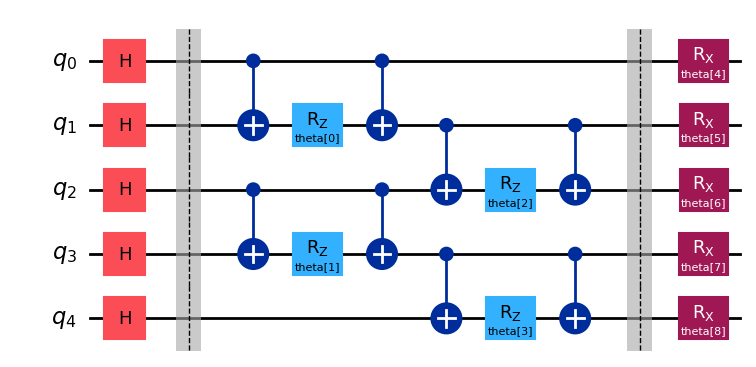

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

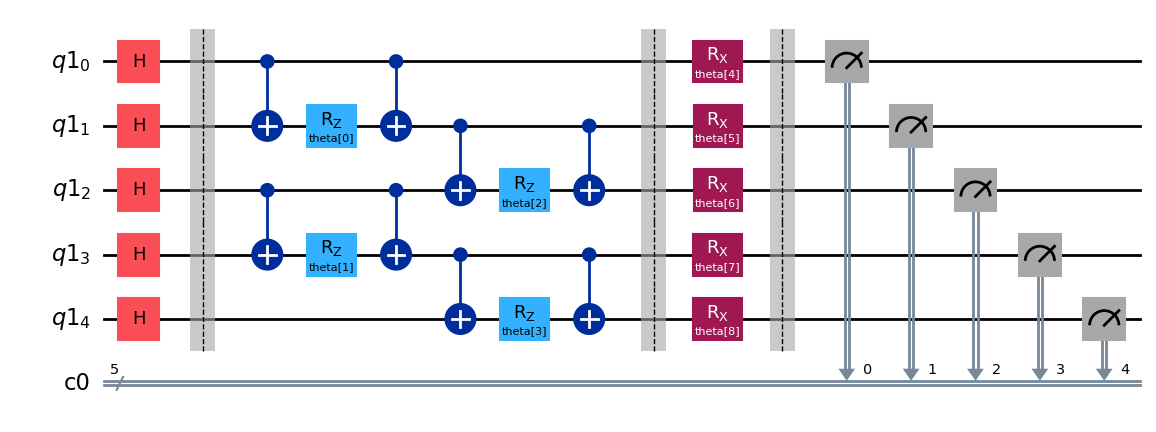

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

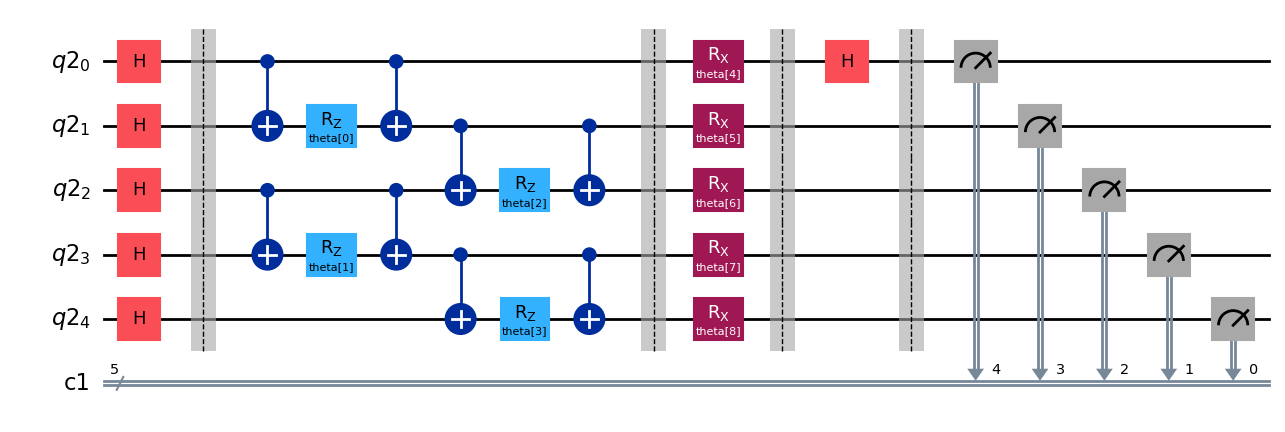

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

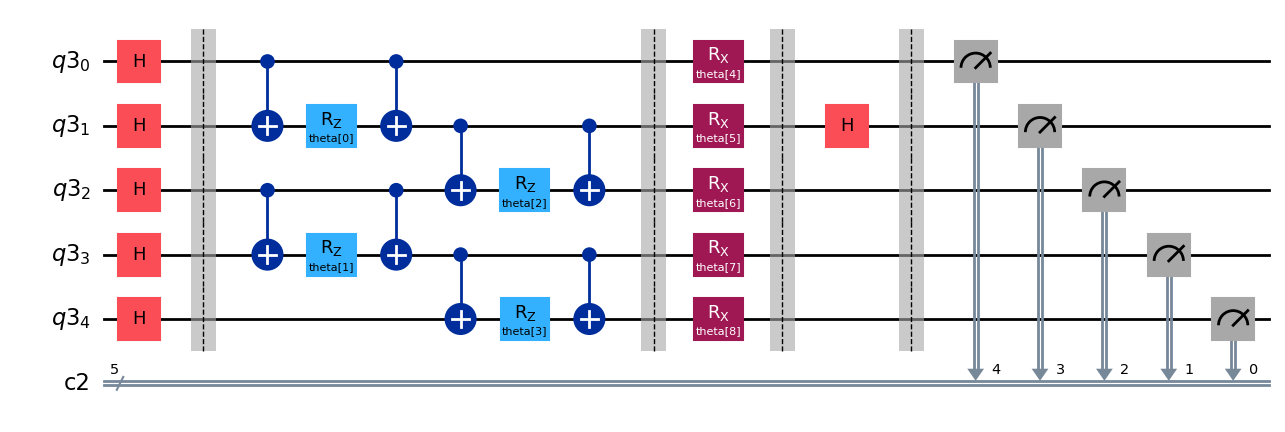

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

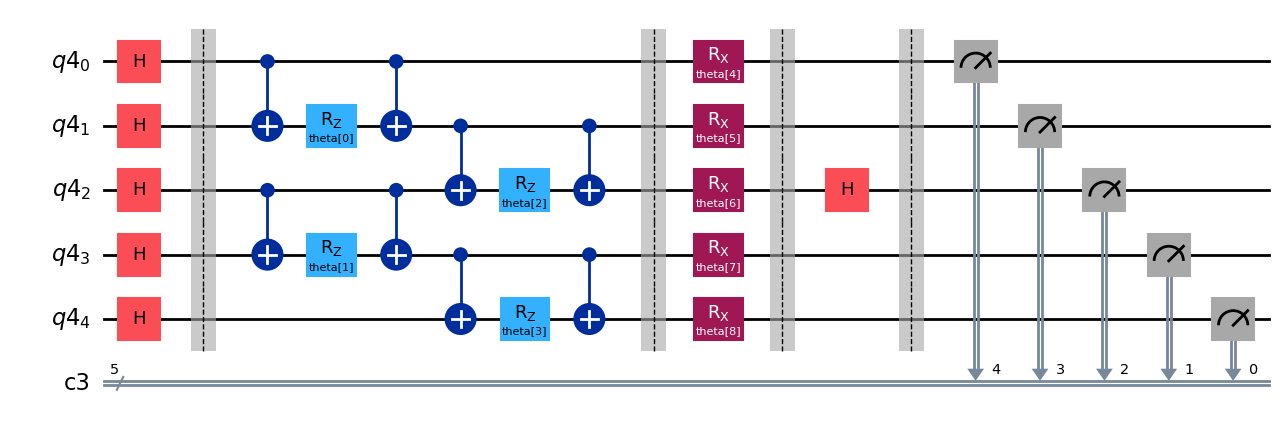

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

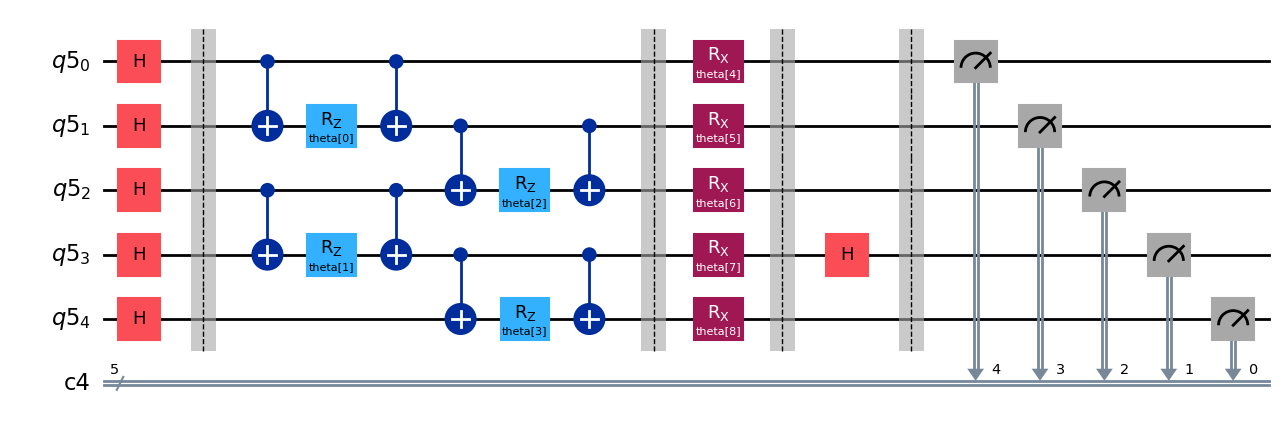

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

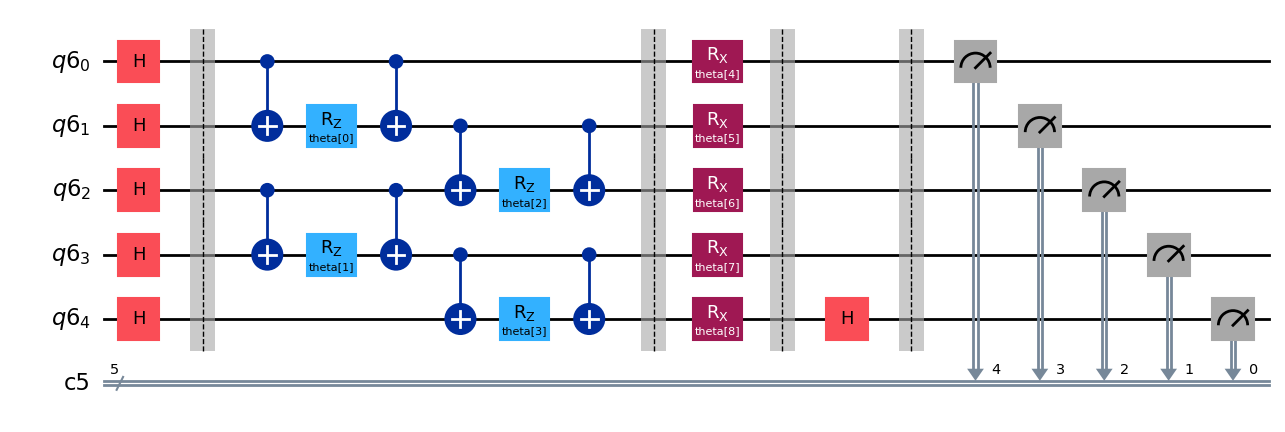

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


def cnn3(vec, x):
  a = vec[0]
  b = vec[1]
  c = vec[2]

  lst = []
  lst.append(b*x[0]+c*x[1])
  lst.append(a*x[0]+b*x[1]+c*x[2])
  lst.append(a*x[1]+b*x[2]+c*x[3])
  lst.append(a*x[2]+b*x[3]+c*x[4])
  lst.append(a*x[3]+b*x[4])

  lst = np.array(lst)

  return lst


def cnn5(vec, x):
  a = vec[0]
  b = vec[1]
  c = vec[2]
  d = vec[3]
  e = vec[4]

  lst = []
  lst.append(c*x[0]+d*x[1]+e*x[2])
  lst.append(b*x[0]+c*x[1]+d*x[2]+e*x[3])
  lst.append(a*x[0]+b*x[1]+c*x[2]+d*x[3]+e*x[4])
  lst.append(a*x[1]+b*x[2]+c*x[3]+d*x[4])
  lst.append(a*x[2]+b*x[3]+c*x[4])

  lst = np.array(lst)

  return lst


def new_cnn(params, x): # x : [6, 5], params : 36 elements (6 * (5 + 1))
  res = np.zeros(6)
  for i in range(6):
    res[i] = np.dot(params[6*i : 6*i+5], x[i]) + params[6*i+5]
  return res


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  a1 = np.array([cnn3(parameter[0:3], x), cnn3(parameter[3:6], x), cnn3(parameter[6:9], x), cnn3(parameter[9:12], x), cnn5(parameter[12:17], x), cnn5(parameter[17:22], x)])
  z1 = relu(a1)

  a2 = new_cnn(parameter[22:58], z1)
  z2 = relu(a2)

  FC1 = parameter[58:88]
  FC2 = parameter[88:93]
  c = parameter[93]

  FC1 = FC1.reshape(5,6)
  FC2 = FC2.reshape(1,5)


  a3 = np.matmul(FC1, z2)
  z3 = relu(a3)

  a4 = np.matmul(FC2, z3)
  y = output_activate(c, a4)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=100000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1]

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  bitflip_prob = error_list[num]

  bit1 = pauli_error([('X', bitflip_prob), ('I', 1 - bitflip_prob)])
  bit2 = bit1.tensor(bit1)

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(bit1, ["u1", "u2", "u3"])
  noise_model.add_all_qubit_quantum_error(bit2, ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=94), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=94), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(bitflip_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

error rate : 0.0, lowest energy vqe : -5.876600000000001

error rate : 0.001, lowest energy vqe : -5.878239999999999

error rate : 0.002, lowest energy vqe : -5.87098

error rate : 0.003, lowest energy vqe : -5.860439999999999



In [ ]:
lowest_energy_vqe_list

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  bitflip_prob = error_list[num]

  bit1 = pauli_error([('X', bitflip_prob), ('I', 1 - bitflip_prob)])
  bit2 = bit1.tensor(bit1)

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(bit1, ["u1", "u2", "u3"])
  noise_model.add_all_qubit_quantum_error(bit2, ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=94), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=94), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(bitflip_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+10, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(94) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 1000
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if len(local_minimum_dict) and local_minimum_dict[-1] < lowest_energy_vqnhe :
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(bitflip_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

In [ ]:
lowest_energy_vqnhe_list

# CNN QEM Plot

## 6. CNN Estimation - Bit Flip Channel

vqe

[-5.876600000000001,
 -5.878239999999999,
 -5.87098,
 -5.860439999999999,
 -5.8485000000000005,
 -5.8170600000000015,
 -5.824020000000002,
 -5.820760000000001,
 -5.8051200000000005,
 -5.798660000000001,
 -5.77824,
 -5.684420000000001,
 -5.59114,
 -5.51376,
 -5.46274,
 -5.3962200000000005,
 -5.35034,
 -5.310279999999999,
 -5.273199999999999,
 -5.24208]

vqnhe FC Hidden Layer 1개

[-6.0084873368912,
 -6.021183539878755,
 -6.014943822537005,
 -6.017577446956279,
 -6.001716601901884,
 -5.986636363681208,
 -5.984354002554103,
 -5.996982454677312,
 -5.972633791317975,
 -5.979476782939116,
 -5.980319277725781,
 -5.989171000294582,
 -6.003600159507773,
 -6.046298053200017,
 -6.03786166098885,
 -6.057769191060488,
 -6.120714748102792,
 -6.1548449824210545,
 -6.167095870646415,
 -6.073861785827551]

vqnhe FC Hidden Layer 2개

[-6.018952, -6.025276, -6.017540, -6.014952, -6.002240107988951, -5.986225585629192, -5.983867787700747, -5.99742223147011, -5.9779223541247335, -5.9795121319115925, -5.984474710604308, -5.988743176942917, -6.005476522671007, -6.046631277747858, -6.039288130947828, -6.058387174047984, -6.121890142835836, -6.151500, -6.168003, -6.075549]

vqnhe CNN ver 1

[-5.98126720351776,
 -5.979827740995574,
 -5.973961267203725,
 -5.947251909851807,
 -5.957522848791658,
 -5.934160621136755,
 -5.923139344068777,
 -5.917016941411954,
 -5.917486403201193,
 -5.91814830802943,
 -5.9023700885348935,
 -5.8731197007311975,
 -5.827900877618601,
 -5.808029758756288,
 -5.79628489668089,
 -5.77700530775198,
 -5.750352682057432,
 -5.754949099972678,
 -5.740653866857386,
 -5.778103785016695]

vqnhe CNN ver 2

[-5.985506314752818,-5.9849511560974,-5.978680136043661,-5.965953494901955,-5.9718400718666205,-5.950212965461465,-5.9343277928659965,-5.939973170673906,-5.9399342390517305,-5.932911936692049,-5.909662123501181,-5.898291139909924,-5.86214586055979,-5.870678500979547,-5.857984080673059,-5.830278056095021,-5.860588989918419,-5.816615960954726,-5.886597146602802,-5.752965110425719]

vqnhe CNN ver 3

[-5.997237682632864,
 -5.9855112832312045,
 -5.992646715552373,
 -5.966829961679886,
 -5.959256240130215,
 -5.953057767459812,
 -5.941178242788786,
 -5.946377093679218,
 -5.92554690791264,
 -5.915426092960993,
 -5.9150689763206445,
 -5.898994940592988,
 -5.857484025143646,
 -5.86618165550624,
 -5.869398861583713,
 -5.869547843864985,
 -5.796642648617699,
 -5.82415424385791,
 -5.810115989271599,
 -5.86859140936705]

Text(0.5, 1.0, 'CNN Estimation at Bit Flip Error Channel (shot 100000)')

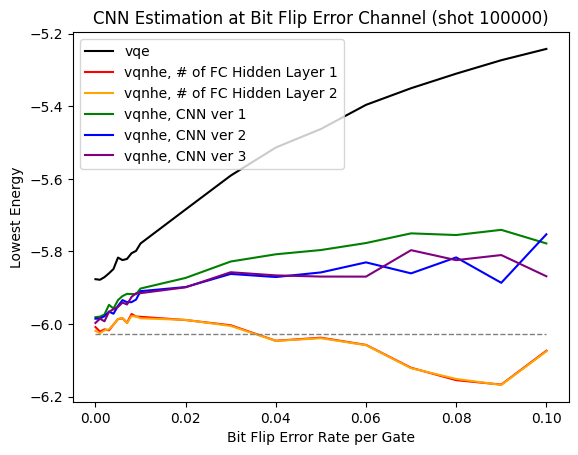

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

vqe = [-5.876600000000001, -5.878239999999999, -5.87098, -5.860439999999999, -5.8485000000000005, -5.8170600000000015, -5.824020000000002, -5.820760000000001, -5.8051200000000005, -5.798660000000001, -5.77824, -5.684420000000001, -5.59114, -5.51376, -5.46274, -5.3962200000000005, -5.35034, -5.310279999999999, -5.273199999999999, -5.24208]
vqnheFC1 = [-6.0084873368912, -6.021183539878755, -6.014943822537005, -6.017577446956279, -6.001716601901884, -5.986636363681208, -5.984354002554103, -5.996982454677312, -5.972633791317975, -5.979476782939116, -5.980319277725781, -5.989171000294582, -6.003600159507773, -6.046298053200017, -6.03786166098885, -6.057769191060488, -6.120714748102792, -6.1548449824210545, -6.167095870646415, -6.073861785827551]
vqnheFC2 = [-6.018952, -6.025276, -6.017540, -6.014952, -6.002240107988951, -5.986225585629192, -5.983867787700747, -5.99742223147011, -5.9779223541247335, -5.9795121319115925, -5.984474710604308, -5.988743176942917, -6.005476522671007, -6.046631277747858, -6.039288130947828, -6.058387174047984, -6.121890142835836, -6.151500, -6.168003, -6.075549]
vqnheCNN1 = [-5.98126720351776, -5.979827740995574, -5.973961267203725, -5.947251909851807, -5.957522848791658, -5.934160621136755, -5.923139344068777, -5.917016941411954, -5.917486403201193, -5.91814830802943, -5.9023700885348935, -5.8731197007311975, -5.827900877618601, -5.808029758756288, -5.79628489668089, -5.77700530775198, -5.750352682057432, -5.754949099972678, -5.740653866857386, -5.778103785016695]
vqnheCNN2 = [-5.985506314752818,-5.9849511560974,-5.978680136043661,-5.965953494901955,-5.9718400718666205,-5.950212965461465,-5.9343277928659965,-5.939973170673906,-5.9399342390517305,-5.932911936692049,-5.909662123501181,-5.898291139909924,-5.86214586055979,-5.870678500979547,-5.857984080673059,-5.830278056095021,-5.860588989918419,-5.816615960954726,-5.886597146602802,-5.752965110425719]
vqnheCNN3 = [-5.997237682632864, -5.9855112832312045, -5.992646715552373, -5.966829961679886, -5.959256240130215, -5.953057767459812, -5.941178242788786, -5.946377093679218, -5.92554690791264, -5.915426092960993, -5.9150689763206445, -5.898994940592988, -5.857484025143646, -5.86618165550624, -5.869398861583713, -5.869547843864985, -5.796642648617699, -5.82415424385791, -5.810115989271599, -5.86859140936705]

plt.plot(error_list, vqe, label="vqe", color="black")
plt.plot(error_list, vqnheFC1, label="vqnhe, # of FC Hidden Layer 1", color="red")
plt.plot(error_list, vqnheFC2, label="vqnhe, # of FC Hidden Layer 2", color="orange")
plt.plot(error_list, vqnheCNN1, label="vqnhe, CNN ver 1", color="green")
plt.plot(error_list, vqnheCNN2, label="vqnhe, CNN ver 2", color="blue")
plt.plot(error_list, vqnheCNN3, label="vqnhe, CNN ver 3", color="purple")

plt.hlines(-6.026674, 0, 0.1,  color='gray', linestyle='--', linewidth=1)
plt.legend()
plt.xlabel("Bit Flip Error Rate per Gate")
plt.ylabel("Lowest Energy")
plt.title("CNN Estimation at Bit Flip Error Channel (shot 100000)")

Text(0.5, 1.0, 'CNN Estimation at Bit Flip Error Channel (shot 100000)')

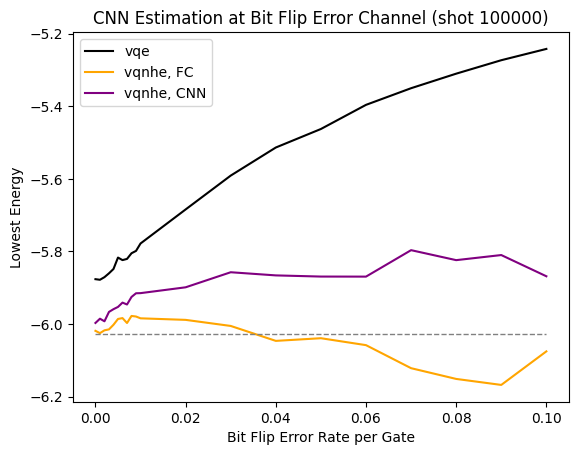

In [ ]:
plt.plot(error_list, vqe, label="vqe", color="black")
plt.plot(error_list, vqnheFC2, label="vqnhe, FC", color="orange")
plt.plot(error_list, vqnheCNN3, label="vqnhe, CNN", color="purple")

plt.hlines(-6.026674, 0, 0.1,  color='gray', linestyle='--', linewidth=1)
plt.legend()
plt.xlabel("Bit Flip Error Rate per Gate")
plt.ylabel("Lowest Energy")
plt.title("CNN Estimation at Bit Flip Error Channel (shot 100000)")